> And the whole question of reinforcement learning is how can we get this ultimate reward that we will get and propagate it back and learned how to behave.                            
--MITx_6.86x

# 前言

## 强化学习基础篇

### 1. 初探强化学习

### 2. 多臂老虎机

#### 2.2. 问题介绍

实现一个拉杆数为 10 的多臂老虎机。其中拉动每根拉杆的奖励服从伯努利分布（Bernoulli distribution），即每次拉下拉杆有的概率获得的奖励为 1，有的概率获得的奖励为 0。奖励为 1 代表获奖，奖励为 0 代表没有获奖。

In [1]:
import collections
import copy
import random
import time
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
from copy import deepcopy

import torch
from tqdm import tqdm

print(torch.cuda.is_available())
import imageio
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

True


In [2]:
class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """

    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
        if np.random.rand() < self.probs[k]:  ## 依概率self.probs[k]返回的奖励1
            return 1
        else:
            return 0  ## 依概率1 - self.probs[k]返回的奖励0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print(f'随机生成了一个{K}臂伯努利老虎机')
print(f'获奖概率最大的拉杆为{bandit_10_arm.best_idx}号,其获奖概率为{bandit_10_arm.best_prob:.4f}')

# 随机生成了一个10臂伯努利老虎机
# 获奖概率最大的拉杆为1号,其获奖概率为0.7203

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


用一个 Solver 基础类来实现上述的多臂老虎机的求解方案。

In [3]:
class Solver:
    """ 多臂老虎机算法基本框架 """

    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        '''
        更新累积懊悔和计数
        '''
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()  ## 根据策略选择拉杆，然后拉动拉杆，算拉杆奖励的期望值
            self.counts[k] += 1  ## 拉动拉杆的次数+1
            self.actions.append(k)  ## 记录每一步的动作action，也就是拉动的拉杆标号
            self.update_regret(k)  ## 更新懊悔地累加值

#### 2.3. Exploration and Exploitation

##### 2.3.1. Epsilon-Greedy

每次以概率 $\epsilon$ 选择随机动作，以概率 $1-\epsilon$ 选择当前最优动作。

estimates增量更新推导：
$$
\begin{align*}
Q_{n+1} &= \frac{1}{n+1} \sum_{i=1}^{n+1} r_{i} \\
     &= \frac{1}{n+1} (r_{n+1} + \sum_{i=1}^{n} r_{i})\\
        &= \frac{1}{n+1} (r_{n+1} + (n) \frac{1}{n} \sum_{i=1}^{n} r_{i})\\
        &= \frac{1}{n+1} (r_{n+1} + (n) Q_{n})\\
        &= Q_{n} + \frac{1}{n+1} (r_{n+1} - Q_{n})
\end{align*}
$$


In [4]:
class EpsilonGreedy(Solver):
    """ 
    epsilon贪婪算法,继承Solver类 
    T随机，R随机
    """

    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆，在0到K之间，左闭右开
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 算第K根拉杆的期望奖励，增量更新的
        return k

直观地展示，可以把每一时间步的累积函数绘制出来

epsilon-贪婪算法的累积懊悔为：25.526630933945313


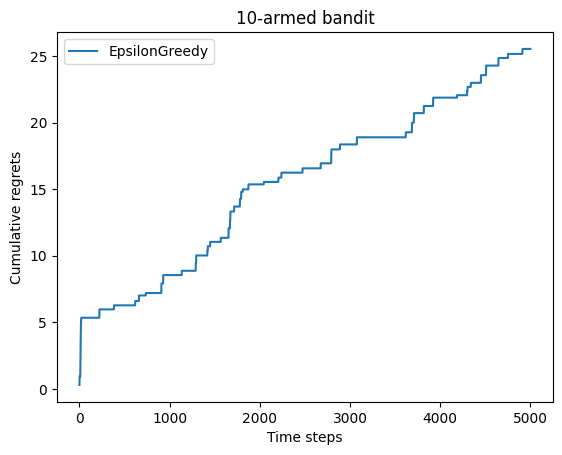

In [5]:
def plot_results(solvers, solver_names):
    """
    生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称
    """
    for idx, solver in enumerate(solvers):  ## 遍历所有的解决方案，实际上只有一个解决方案
        time_list = range(len(solver.regrets))  ## 每一步的懊悔记录，拿到横轴的数值
        plt.plot(time_list, solver.regrets, label=solver_names[idx])  # 绘制，横轴是时间步，纵轴是懊悔值
    plt.xlabel('Time steps')  ##  横轴的标签
    plt.ylabel('Cumulative regrets')  ##  纵轴的标签
    plt.title(f'{solvers[0].bandit.K}-armed bandit')  ##  标题
    plt.legend()  ##  图例
    plt.show()  ##  显示图片的


np.random.seed(1)  ## 初始化随机数的 seed 种子
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm)  ## 策略器初始化
epsilon_greedy_solver.run(5000)  ## 拉动拉杆共五千次，然后运算累加懊悔，每个杆的期望奖励等
print(f'epsilon-贪婪算法的累积懊悔为：{epsilon_greedy_solver.regret}')
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

# epsilon-贪婪算法的累积懊悔为：25.526630933945313

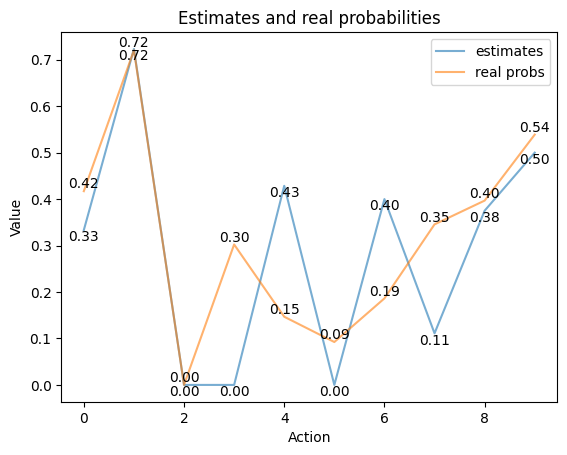

In [6]:
# 绘制概率图
def plot_estimates(bandit, solver):
    x = range(bandit.K)
    plt.plot(x, solver.estimates, alpha=0.6, label='estimates')
    plt.plot(x, bandit.probs, alpha=0.6, label='real probs')
    plt.xlabel('Action')
    plt.ylabel('Value')
    plt.title('Estimates and real probabilities')
    plt.legend()
    for i in range(bandit.K):
        plt.text(i, bandit.probs[i], f'{bandit.probs[i]:.2f}', ha='center', va='bottom')
        plt.text(i, solver.estimates[i], f'{solver.estimates[i]:.2f}', ha='center', va='top')
    plt.show()


plot_estimates(bandit_10_arm, epsilon_greedy_solver)

尝试不同的参数 $\epsilon$，并比较不同参数下的累积懊悔值。

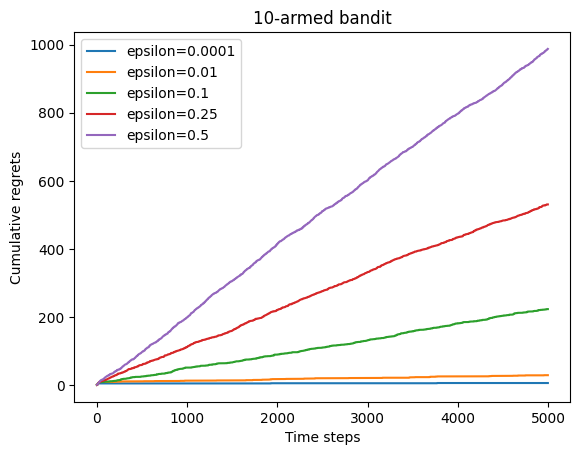

In [7]:
np.random.seed(0)  ## 给定随机种子，保证实验可以复现
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]  ## 不同的ε值
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons  ## 初始化不同的策略解决方案
]
epsilon_greedy_solver_names = [f"epsilon={e}" for e in epsilons]  ## 不同ε值对应的名称
for solver in epsilon_greedy_solver_list:  ## 遍历策略解决方案，每个策略运行五千次
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)  ## 绘制图像的

尝试$\epsilon$值随时间反比例衰减的策略，即 $\epsilon = \frac{1}{t}$。

epsilon值衰减的贪婪算法的累积懊悔为：10.114334931260183


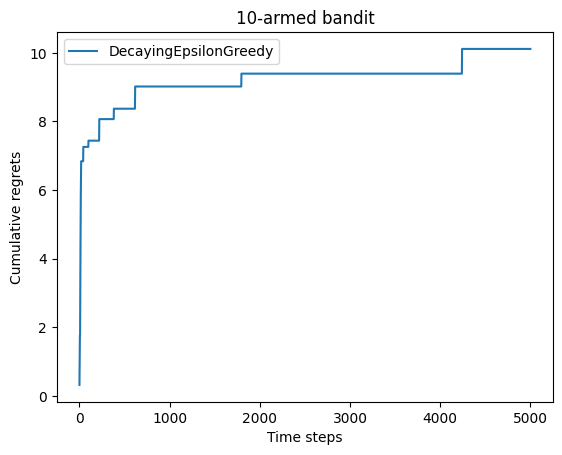

In [8]:
class DecayingEpsilonGreedy(Solver):
    """ 
    epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 
    """

    def __init__(self, bandit, init_prob=1.0):
        super().__init__(bandit)  ## 初始化基类Solver
        self.estimates = np.array([init_prob] * self.bandit.K)  ## 初始化每根拉杆的期望奖励，=1
        self.total_count = 0  ## 拉杆的总次数

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        self.total_count += 1  ## 拉杆的次数+1，此时ε=拉杆次数的倒数，拉杆次数越多ε越小
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)  ## 此时有ε的概率随机选择拉杆
        else:
            k = np.argmax(self.estimates)  ## 此时有1-ε的概率选择期望奖励最大的拉杆

        r = self.bandit.step(k)  ## 获得第k根拉杆的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 增量更新期望奖励

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)  ## 初始化延迟策略解决方案
decaying_epsilon_greedy_solver.run(5000)  ## 运行五千次拉杆操作的
print(f'epsilon值衰减的贪婪算法的累积懊悔为：{decaying_epsilon_greedy_solver.regret}')
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])  ## 绘制图像的

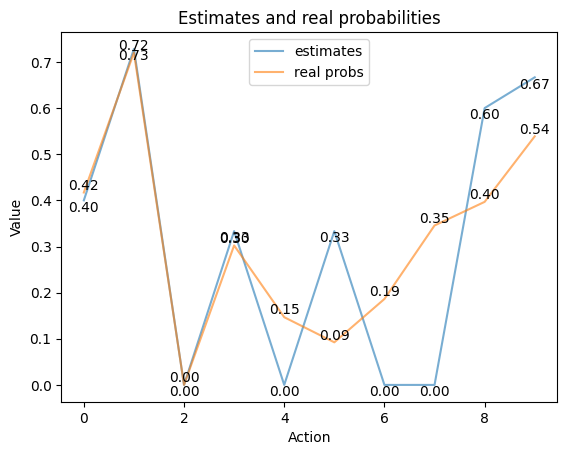

In [9]:
# 绘制概率图
plot_estimates(bandit_10_arm, decaying_epsilon_greedy_solver)

##### 2.3.2. Upper Confidence Bound (UCB)上置信界算法

霍夫丁不等式（Hoeffding's inequality）
$$
\begin{align*}
P(E(x) \geq \bar{x}_n + \epsilon) \leq e^{-2n\epsilon^2} &= p\\
\ln p &= -2n\epsilon^2\\
\epsilon &= \sqrt{\frac{-\ln p}{2n}}
\end{align*}
$$
即 $Q_t(a)$ 以$1-p$的概率 $< \hat{Q}_t(a) + \sqrt{\frac{-\ln p}{2n}}$。

令 $p = \frac{1}{t}$，则 $\epsilon = \sqrt{\frac{\ln t}{2n}}$。

为避免除数为0，为每根拉杆的尝试次数加上1，即 $\epsilon = \sqrt{\frac{\ln t}{2(n+1)}}$。

设定一个系数c来控制不确定性的比重，即 $Q_t(a) = \hat{Q}_t(a) + c\sqrt{\frac{\ln t}{2(n+1)}}$。

上置信界算法的累积懊悔为：70.45281214197854


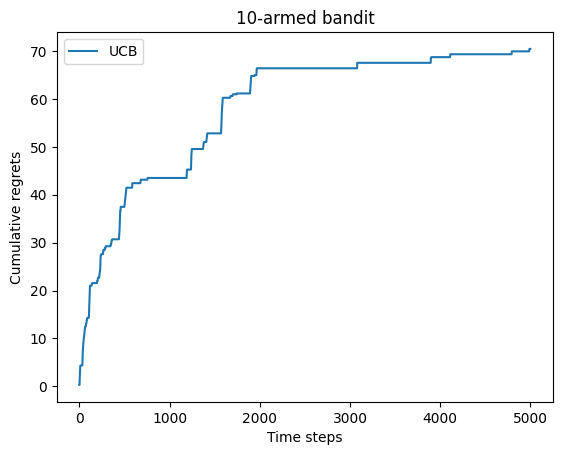

In [10]:
class UCB(Solver):
    """ 
    UCB算法,继承Solver类 
    T选π，R随机
    """

    def __init__(self, bandit, coef, init_prob=1.0):  ##  初始化ucb类的
        super().__init__(bandit)  ##  初始化基类Solver
        self.total_count = 0  ##  总的拉杆次数
        self.estimates = np.array([init_prob] * self.bandit.K)  ## 初始化每根拉杆的期望奖励
        self.coef = coef  ## ucb的权重

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        self.total_count += 1  ##  运行的总次数+1

        ## 算出所有拉杆的期望奖励上界
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆(期望奖励上界最大的动作)
        r = self.bandit.step(k)  ## 拿到奖励的数值
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 增量更新对应拉杆的期望奖励
        return k


np.random.seed(1)  ## 给定随机数种子，方便复现的
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)  ## 实例化ucb类的
UCB_solver.run(5000)  ## 共拉杆五千次
print(f'上置信界算法的累积懊悔为：{UCB_solver.regret}')
plot_results([UCB_solver], ["UCB"])  ## 绘制图像的

# 上置信界算法的累积懊悔为： 70.45281214197854

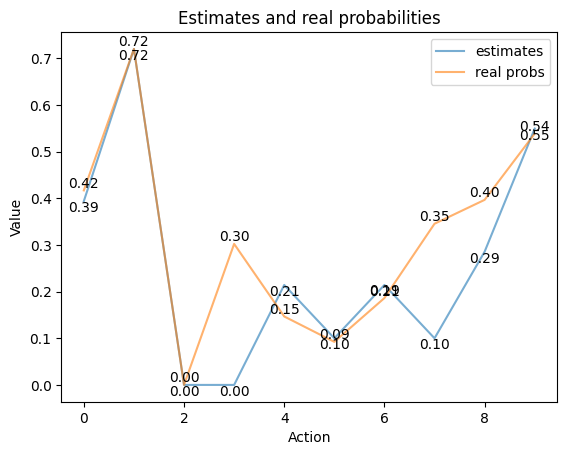

In [11]:
# 绘制概率图
plot_estimates(bandit_10_arm, UCB_solver)

##### 2.3.3. Thompson Sampling

假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来进行选择。

通常用 Beta 分布对当前每个动作的奖励概率分布进行建模。具体来说，若某拉杆被选择了 $k$ 次，其中$m_1$次获奖，$m_0$次未获奖，则该拉杆的奖励概率服从参数为$(m_1+1, m_0+1)$的 Beta 分布。

汤普森采样算法的累积懊悔为：57.19161964443925


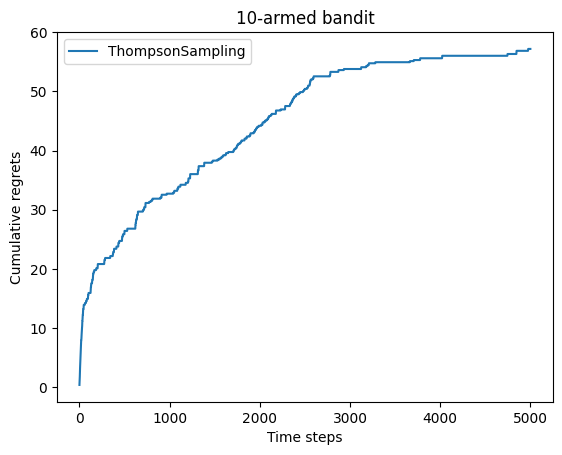

In [12]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """

    def __init__(self, bandit):
        super().__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        '''
        根据策略pi选择动作a、根据动作a获取奖励r和更新期望奖励估值v
        '''
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

    def run(self, num_steps):
        '''
        更新累积懊悔和计数
        '''
        super().run(num_steps)
        # 完成后使用Beta分布的期望值来估计每根拉杆的获奖概率
        self.estimates = self._a / (self._a + self._b)


np.random.seed(1)  ## 给定随机数种子，方便复现的
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)  ## 实例化Thompson类的
thompson_sampling_solver.run(5000)  ## 共拉杆五千次
print(f'汤普森采样算法的累积懊悔为：{thompson_sampling_solver.regret}')
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

# 汤普森采样算法的累积懊悔为：57.19161964443925

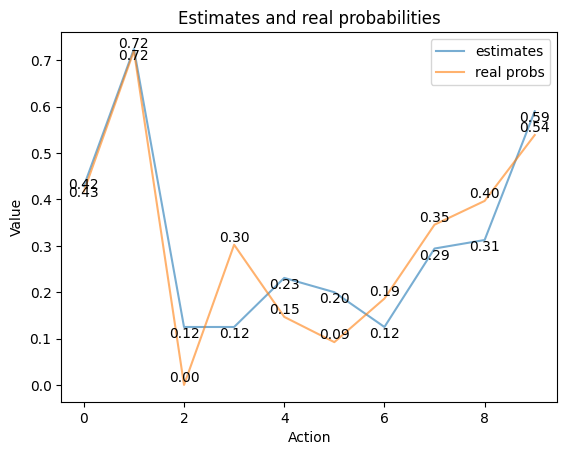

In [13]:
# 绘制概率图
plot_estimates(bandit_10_arm, thompson_sampling_solver)

### 3. 马尔可夫决策过程

> Markov decision processes are an extension of Markov chains; the difference is the addition of actions (allowing choice) and rewards (giving motivation). Conversely, if only one **a**ction exists for each state (e.g. “wait”) and all **r**ewards are the same (e.g. “zero”), a Markov decision process reduces to a Markov chain.”

#### 3.3. Utility Function

- why not finite horizon utility?

if you just go one step to go, you may go to extremely risky behaviour because you have no other chances.

- The main problem for MDPs is to optimize the agent’s behavior. To do so, **we first need to specify the criterion that we are trying to maximize in terms of accumulated rewards.**

$ U \leq \frac{R_{max}}{1-\lambda}  $

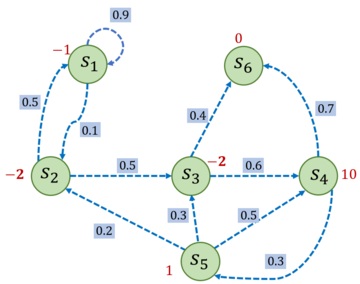

s1-s2-s3-s6

In [14]:

np.random.seed(0)
# 定义状态转移概率矩阵T
T = [
    [0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
    [0.0, 0.2, 0.3, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
]
T = np.array(T)

rewards = [-1, -2, -2, 10, 1, 0]  # 定义奖励函数
gamma = 0.5  # 定义折扣因子


# chain：序列
# gamma：折扣因子
# 给定一条序列,计算从某个索引（起始状态）开始到序列最后（终止状态）得到的回报


def compute_return(start_index, chain, gamma):
    G = 0
    ret = []
    for i in reversed(range(start_index, len(chain))):  ## 运算的方向要倒着来
        g_ = deepcopy(G)
        G = gamma * G + rewards[chain[i] - 1]  ## 从后往前依次运算求出结果
        ret.append([G, gamma, g_, rewards[chain[i] - 1], chain[i]])  ## 保存
    '''
    https://zhuanlan.zhihu.com/p/655615836
     0.0 = 0.5 *  0     +   0         6
    -2.0 = 0.5 *  0     +  -2         6->3
    -3.0 = 0.5 * -2.0   +  -2         3->2
    -2.5 = 0.5 * -3.0   +  -1         2->1
   ret=    [[ 0.0, 0.5,  0,    0, 6], 
            [-2.0, 0.5,  0.0, -2, 3], 
            [-3.0, 0.5, -2.0, -2, 2], 
            [-2.5, 0.5, -3.0, -1, 1]]
    '''
    return G


# 一个状态序列,s1-s2-s3-s6
chain = [1, 2, 3, 6]
start_index = 0
G = compute_return(start_index, chain, gamma)
print(f'根据本序列计算得到回报为：{G}')

# 根据本序列计算得到回报为：-2.5。

根据本序列计算得到回报为：-2.5


##### 3.3.2. Value Function

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

Value Function使用Bellman equation的解析解
$$
\begin{align*}
V &= R + \gamma TV \\
(I - \gamma T) V &= R \\
V &= (I - \gamma T)^{-1} R 
\end{align*}
$$

In [15]:
def compute(T, rewards, gamma, states_num):
    ''' 利用贝尔曼方程的矩阵形式计算解析解,states_num是MRP的状态数 '''
    rewards = np.array(rewards).reshape((-1, 1))  #将rewards写成列向量形式    ## r：每个状态的奖励值
    ## 对应求解析解的公式，V=(1-γP)^(-1)r
    # value = np.dot(np.linalg.inv(np.eye(states_num, states_num) - gamma * T), rewards)
    value = np.asmatrix(np.eye(states_num) - gamma * T).I @ rewards

    return value


V = compute(T, rewards, gamma, 6)
print("MRP中每个状态价值分别为\n", V)

# MRP中每个状态价值分别为
#  [[-2.01950168]
#  [-2.21451846]
#  [ 1.16142785]
#  [10.53809283]
#  [ 3.58728554]
#  [ 0.        ]]

MRP中每个状态价值分别为
 [[-2.01950168]
 [-2.21451846]
 [ 1.16142785]
 [10.53809283]
 [ 3.58728554]
 [ 0.        ]]


#### 3.4. 马尔可夫决策过程（Markov decision process，MDP）

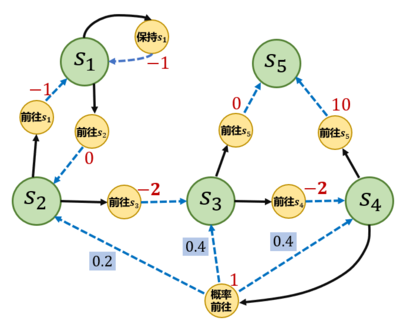

##### 3.4.2. Q-value Function 动作价值函数 action-value function

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

In [16]:
S = ["s1", "s2", "s3", "s4", "s5"]  # 状态集合
A = ["保持s1", "前往s1", "前往s2", "前往s3", "前往s4", "前往s5", "概率前往"]  # 动作集合
# 状态转移函数
T = {
    "s1-保持s1-s1": 1.0,
    "s1-前往s2-s2": 1.0,
    "s2-前往s1-s1": 1.0,
    "s2-前往s3-s3": 1.0,
    "s3-前往s4-s4": 1.0,
    "s3-前往s5-s5": 1.0,
    "s4-前往s5-s5": 1.0,
    "s4-概率前往-s2": 0.2,
    "s4-概率前往-s3": 0.4,
    "s4-概率前往-s4": 0.4,
}
# 奖励函数
R = {
    "s1-保持s1": -1,
    "s1-前往s2": 0,
    "s2-前往s1": -1,
    "s2-前往s3": -2,
    "s3-前往s4": -2,
    "s3-前往s5": 0,
    "s4-前往s5": 10,
    "s4-概率前往": 1,
}
gamma = 0.5  # 折扣因子
MDP = (S, A, T, R, gamma)

# 策略π1,随机策略
pi_1 = {
    "s1-保持s1": 0.5,
    "s1-前往s2": 0.5,
    "s2-前往s1": 0.5,
    "s2-前往s3": 0.5,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.5,
    "s4-概率前往": 0.5,
}
# 策略π2
pi_2 = {
    "s1-保持s1": 0.6,
    "s1-前往s2": 0.4,
    "s2-前往s1": 0.3,
    "s2-前往s3": 0.7,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.1,
    "s4-概率前往": 0.9,
}


# 把输入的两个字符串通过“-”连接,便于使用上述定义的T、R变量
def join(str1, str2):
    return str1 + '-' + str2

转化后的 MRP 的状态转移矩阵和奖励函数

In [17]:
gamma = 0.5
# 转化后的MRP的状态转移矩阵
T_from_mdp_to_mrp = [
    [0.5, 0.5, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.5, 0.5],
    [0.0, 0.1, 0.2, 0.2, 0.5],
    [0.0, 0.0, 0.0, 0.0, 1.0],
]
'''
T(1|1) = pi_1["s1-保持s1"] * T["s1-保持s1-s1"] = 1 * 0.5 = 0.5
T(2|1) = pi_1["s1-前往s2"] * T["s1-前往s2-s2"] = 1 * 0.5 = 0.5
T(1|2) = pi_1["s2-前往s1"] * T["s2-前往s1-s1"] = 1 * 0.5 = 0.5
T(3|2) = pi_1["s2-前往s3"] * T["s2-前往s3-s3"] = 1 * 0.5 = 0.5
T(4|3) = pi_1["s3-前往s4"] * T["s3-前往s4-s4"] = 1 * 0.5 = 0.5
T(5|3) = pi_1["s3-前往s5"] * T["s3-前往s5-s5"] = 1 * 0.5 = 0.5
T(2|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s2"] = 0.5 * 0.2 = 0.1
T(3|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s3"] = 0.5 * 0.4 = 0.2
T(4|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s4"] = 0.5 * 0.4 = 0.2
T(5|4) = pi_1["s4-前往s5"] * T["s4-前往s5-s5"] = 0.5 * 1 = 0.5
T(5|5) = 1
'''
T_from_mdp_to_mrp = np.array(T_from_mdp_to_mrp)
R_from_mdp_to_mrp = [-0.5, -1.5, -1.0, 5.5, 0]  ## MDP转MRP以后的状态奖励
'''
r(s1) = pi_1["s1-保持s1"] * R["s1-保持s1"] + pi_1["s1-前往s2"] * R["s1-前往s2"] = -1 * 0.5 + 0 * 0.5 = -0.5
r(s2) = pi_1["s2-前往s1"] * R["s2-前往s1"] + pi_1["s2-前往s3"] * R["s2-前往s3"] = -1 * 0.5 + -2 * 0.5 = -1.5
r(s3) = pi_1["s3-前往s4"] * R["s3-前往s4"] + pi_1["s3-前往s5"] * R["s3-前往s5"] = -2 * 0.5 + 0 * 0.5 = -1
r(s4) = pi_1["s4-前往s5"] * R["s4-前往s5"] + pi_1["s4-概率前往"] * R["s4-概率前往"] = 10 * 0.5 + 1 * 0.5 = 5.5
r(s5) = 0
也就求出了T_from_mdp_to_mrp 奖励函数的
'''

V = compute(T_from_mdp_to_mrp, R_from_mdp_to_mrp, gamma, 5)  # 解析解
print("MDP中每个状态价值分别为\n", V)

# MDP中每个状态价值分别为
#  [[-1.22555411]
#  [-1.67666232]
#  [ 0.51890482]
#  [ 6.0756193 ]
#  [ 0.        ]]

MDP中每个状态价值分别为
 [[-1.22555411]
 [-1.67666232]
 [ 0.51890482]
 [ 6.0756193 ]
 [ 0.        ]]


#### 3.5. 蒙特卡罗方法MC

In [18]:
def sample(MDP, pi, timestep_max, number):
    ''' 采样函数,策略Pi,限制最长时间步timestep_max,总共采样序列数number '''
    S, A, T, R, gamma = MDP
    episodes = []
    for _ in range(number):
        episode = []
        timestep = 0
        s = S[np.random.randint(4)]  # 随机选择一个除s5以外的状态s作为起点
        # 当前状态为终止状态或者时间步太长时,一次采样结束
        while s != "s5" and timestep <= timestep_max:
            timestep += 1
            rand, temp = np.random.rand(), 0  ## 初始化概率，以及动作概率是0
            # 在状态s下根据策略选择动作
            for a_opt in A:  ## 遍历每个动作
                temp += pi.get(join(s, a_opt), 0)  ## 拿到状态+动作的名称，然后从策略pi_1内拿到对应的动作概率
                # fix me: 此处有bug，pi中a_opt的顺序对动作执行有影响，如：动作1动作2均为0.5，rand为0.6，始终选择动作2
                if temp > rand:  ## 该状态和动作对应的概率，满足概率条件，则执行动作action
                    a = a_opt  ## 执行动作的action，a是动作名称
                    r = R.get(join(s, a), 0)  ## 拿到状态+动作的名称，然后从状态+动作的奖励 R 内拿到对应的动作奖励
                    break  ## 已经执行了动作，退出动作的循环
            rand, temp = np.random.rand(), 0  ## 初始化概率，以及状态的概率
            # 根据状态转移概率得到下一个状态s_next
            for s_opt in S:  ## 遍历状态列表
                temp += T.get(join(join(s, a), s_opt), 0)  ## 组合了状态+动作+转移的状态名称，然后从状态+动作+转移状态的概率 T 内拿到对应的转移概率
                if temp > rand:  ##    满足概率条件，则执行状态转移
                    s_next = s_opt  ##    转移到的状态是 s_next
                    break  ##    已经转移了状态，退出状态的循环
            ## s是当前的状态，a是执行的动作，r是执行动作的奖励，s_next是执行动作以后转移到的状态
            episode.append((s, a, r, s_next))  # 把（s,a,r,s_next）元组放入序列中
            s = s_next  # s_next变成当前状态,开始接下来的循环
        episodes.append(episode)
    return episodes


# 采样5次,每个序列最长不超过1000步
episodes = sample(MDP, pi_1, 20, 5)
print('第一条序列\n', episodes[0])
print('第二条序列\n', episodes[1])
print('第五条序列\n', episodes[4])

# 第一条序列
#  [('s1', '前往s2', 0, 's2'), ('s2', '前往s3', -2, 's3'), ('s3', '前往s5', 0, 's5')]
# 第二条序列
#  [('s4', '概率前往', 1, 's4'), ('s4', '前往s5', 10, 's5')]
# 第五条序列
#  [('s2', '前往s3', -2, 's3'), ('s3', '前往s4', -2, 's4'), ('s4', '前往s5', 10, 's5')]

第一条序列
 [('s1', '前往s2', 0, 's2'), ('s2', '前往s3', -2, 's3'), ('s3', '前往s5', 0, 's5')]
第二条序列
 [('s4', '概率前往', 1, 's4'), ('s4', '前往s5', 10, 's5')]
第五条序列
 [('s2', '前往s3', -2, 's3'), ('s3', '前往s4', -2, 's4'), ('s4', '前往s5', 10, 's5')]


In [19]:
# 对所有采样序列计算所有状态的价值
def MC(episodes, V, N, gamma):
    for episode in episodes:
        G = 0
        for i in reversed(range(len(episode))):  ## 一个序列从后往前计算
            (s, a, r, s_next) = episode[i]  # 从序列中取出一个元组（s,a,r,s_next）
            G = r + gamma * G  # 计算折扣累计奖励
            N[s] += 1  # 记录状态s出现的次数
            # 计算状态s的价值，每次更新时只改变当前状态的价值
            V[s] += (G - V[s]) / N[s]


timestep_max = 20
# 采样1000次,可以自行修改
episodes = sample(MDP, pi_1, timestep_max, 10000)
gamma = 0.5
V = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
N = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
MC(episodes, V, N, gamma)
print("使用蒙特卡洛方法计算MDP的状态价值为\n", V)

# 使用蒙特卡洛方法计算MDP的状态价值为
#  {'s1': -1.228923788722258, 's2': -1.6955696284402704, 's3': 0.4823809701532294,
# 's4': 5.967514743019431, 's5': 0}

使用蒙特卡洛方法计算MDP的状态价值为
 {'s1': -1.2206481669904494, 's2': -1.6886433026750503, 's3': 0.49346512992377956, 's4': 6.037788973046783, 's5': 0}


#### 3.6. 占用度量

In [20]:
def occupancy(episodes, s, a, timestep_max, gamma):
    ''' 计算状态动作对（s,a）出现的频率,以此来估算策略的占用度量 '''
    rho = 0  # 初始化占用度量
    total_times = np.zeros(timestep_max)  # 初始化每个时间步t各被经历过几次
    occur_times = np.zeros(timestep_max)  # 初始化(s_t,a_t)=(s,a)的次数
    for episode in episodes:  ## 遍历每个采样的内容
        for i in range(len(episode)):  ## 遍历每个采样内部的状态、动作的内容
            (s_opt, a_opt, r, s_next) = episode[i]  ## 拿到每个采样内的 状态、动作、动作的奖励、下一个状态
            total_times[i] += 1  ## 统计序列所在index的次数（时间步t各被经历过几次）
            if s == s_opt and a == a_opt:  ## 状态、动作和给定的相同
                occur_times[i] += 1  ## 也就是（状态，动作）对的次数+1
    # for i in reversed(range(timestep_max)):  ## 逆序算占用度量
    # fix me：不需要逆序？
    for i in range(timestep_max):
        if total_times[i]:  ## 序列所在的index有值
            rho += gamma ** i * occur_times[i] / total_times[i]  ## 按照公式运算
    return (1 - gamma) * rho


gamma = 0.5  #折扣因子
timestep_max = 1000  #最大时间步长

episodes_1 = sample(MDP, pi_1, timestep_max, 1000)  ## 采样，参数是MDP，pi_1是策略，timestep_max是最长时间步，10000是采样的次数
episodes_2 = sample(MDP, pi_2, timestep_max, 1000)  ## 和上面只有策略不同，pi_2
rho_1 = occupancy(episodes_1, "s4", "概率前往", timestep_max, gamma)  ## 算占用度量
rho_2 = occupancy(episodes_2, "s4", "概率前往", timestep_max, gamma)
print(rho_1, rho_2)

# 0.112567796310472 0.23199480615618912

0.117927768265181 0.23436384017172737


### 4. 动态规划算法

#### 4.1. 简介

基于动态规划的强化学习算法主要有两种：一是**策略迭代（policy iteration）**，二是**价值迭代（value iteration）**。

只适用于有限马尔可夫决策过程，即状态空间和动作空间是离散且有限的。

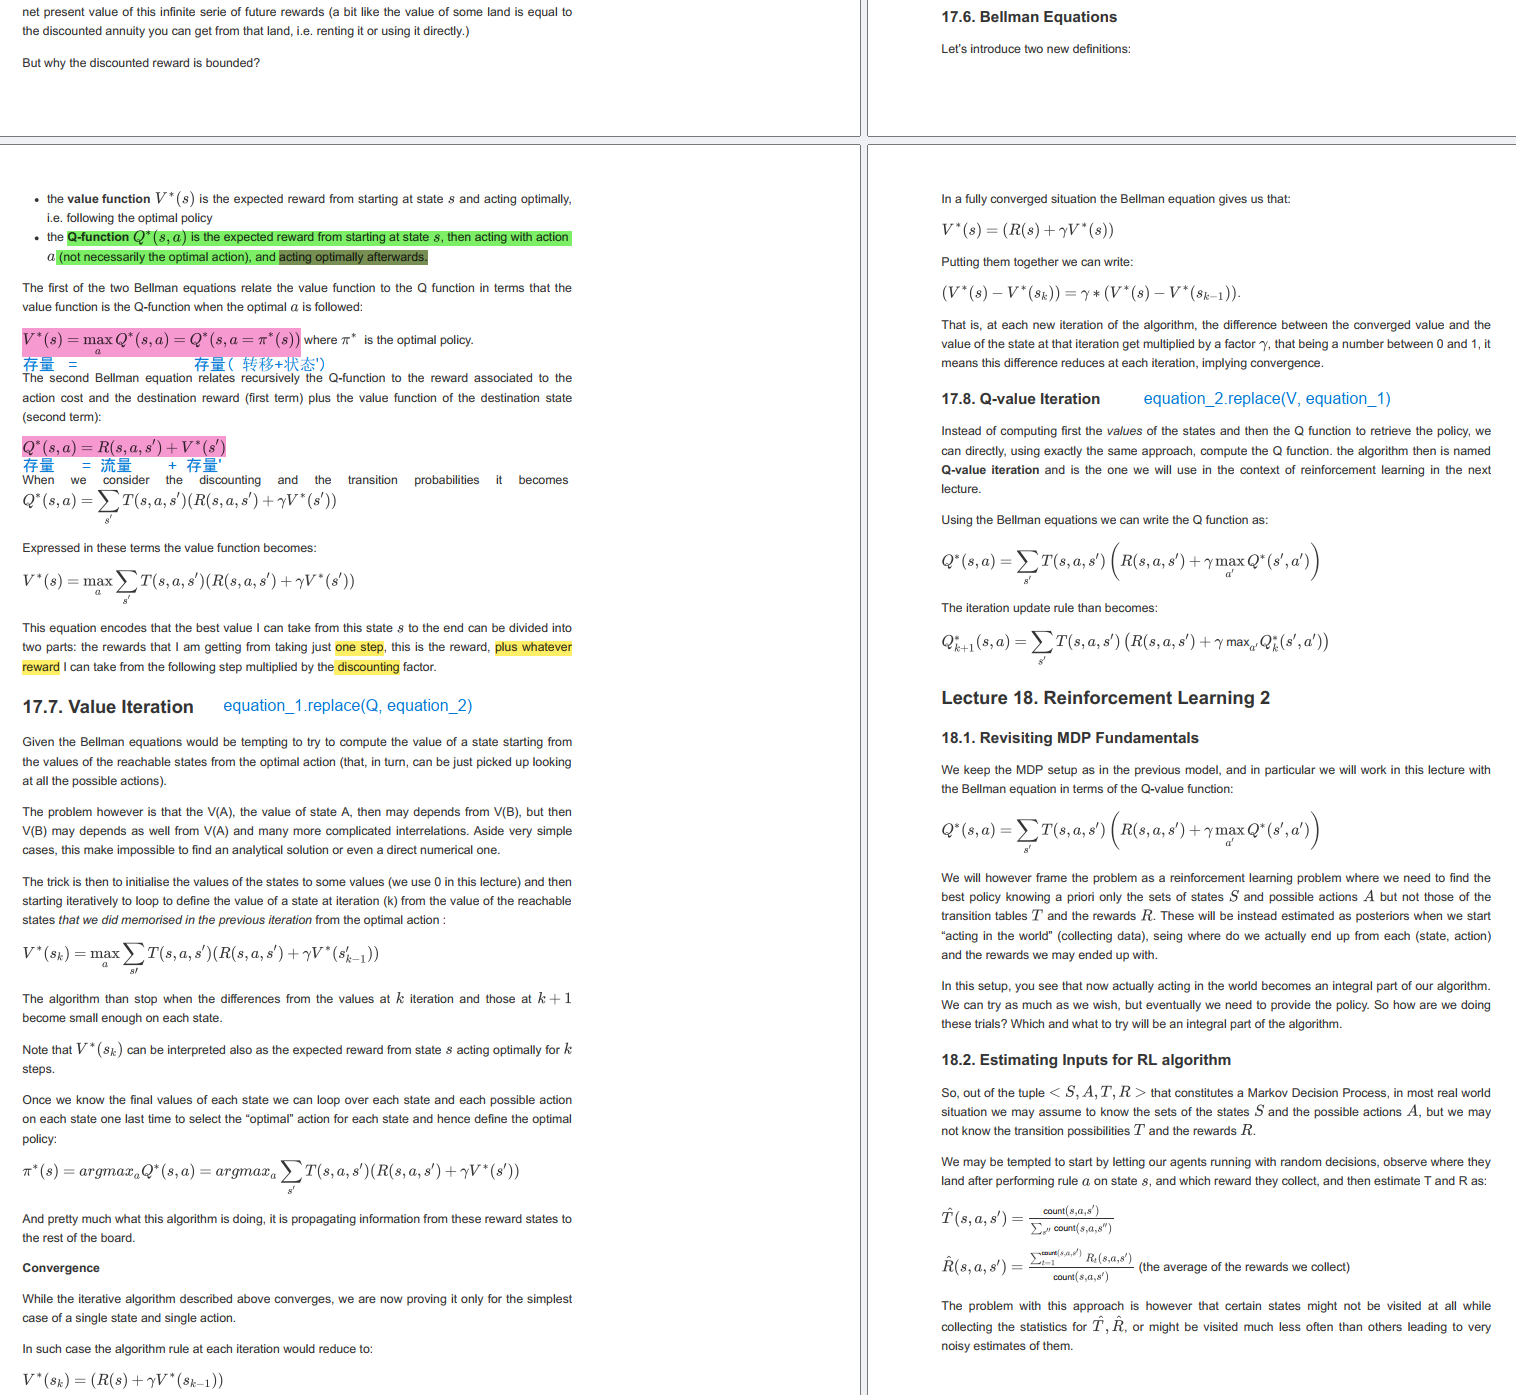

#### 4.2. 悬崖漫步环境

|0|1|2|3|4|5|6|7|8|9|10|11|
|-|-|-|-|-|-|-|-|-|-|-|-|
|12|13|14|15|16|17|18|19|20|21|22|23|
|24|25|26|27|28|29|30|31|32|33|34|35|
|36|37|38|39|40|41|42|43|44|45|46|47|

In [21]:
class CliffWalkingEnv:
    """ 悬崖漫步环境"""

    def __init__(self, ncol=12, nrow=4):
        self.ncol = ncol  # 定义网格世界的列
        self.nrow = nrow  # 定义网格世界的行
        # 转移矩阵P[state][action] = [(p, s_, reward, done)]包含下一个状态和奖励
        self.P = self.createP()

    def createP(self):
        # 初始化
        P = [[[] for j in range(4)] for i in range(self.nrow * self.ncol)]  # 48*4
        # 4种动作, change[0]:上,change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        for r in range(self.nrow):
            for c in range(self.ncol):
                s = r * self.ncol + c  ##  当前状态
                for a in range(4):
                    #   位置在悬崖或者目标状态,因为无法继续交互,任何动作奖励都为0
                    ##  最后一行是悬崖的，处在悬崖是不可能的，所以可以任意初始化 
                    if r == self.nrow - 1 and c > 0:
                        P[s][a] = [(1, s, 0, True)]
                        continue
                    # 其他位置
                    ## 其他地方的下个状态，或者说下个x坐标，都要满足在格子内部，若是可能移动到网格的外部，下一步就保持不动
                    c_ = min(self.ncol - 1, max(0, c + change[a][0]))  # 限制在0~11之间
                    r_ = min(self.nrow - 1, max(0, r + change[a][1]))  # 限制在0~3之间
                    s_ = r_ * self.ncol + c_  ##  下个状态的数组地址
                    reward = -1  ## 奖励值初始化到 -1
                    done = False  ##  默认没有达到终止条件（下个坐标在悬崖，或者在终点）
                    # 下一个位置在悬崖或者终点
                    if r_ == self.nrow - 1 and c_ > 0:  ## 最后一行是悬崖的
                        if c_ != self.ncol - 1:  # 下一个位置在悬崖
                            reward = -100  ## 下个坐标是悬崖，奖励是-100
                        done = True  ## 达到了终止条件
                    ##  对给定的动作a，下一步的转移到s_概率是1，reward是动作奖励，done表示是否终止
                    P[s][a] = [(1, s_, reward, done)]
        # print(f'P:{P}')
        return P

#### 4.3. 策略迭代算法（Value Iteration）

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

In [22]:
class BaseIteration:
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.theta = theta  # 策略评估收敛阈值
        self.gamma = gamma  # 折扣因子
        # 价值迭代结束后得到的策略
        self.pi = [None for i in range(self.env.ncol * self.env.nrow)]

    def policy_improvement(self):
        '''
        策略提升：基于v，更新pi
        '''
        for s in range(self.env.nrow * self.env.ncol):  ##  遍历所有的状态
            qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
            for a in range(4):  ##  遍历所有的动作，上下左右这几个方向
                qsa = 0  ##  动作价值初始化到0
                ## 遍历（s,a）对应的s转移可能，拿到T（s,a,s'）、s'、动作的奖励r、是否终止的
                ## 此处对应的self.env.P[s][a]的长度都是1（1个4元组），也就是执行某个动作以后，该动作只能转移到某个确定的状态，不能按T转移到多个状态
                for res in self.env.P[s][a]:
                    p, s_, r, done = res  ## 状态转移概率此处=1、下个状态、动作的奖励r(该循环内不变)、是否终止的
                    qsa += p * (r + self.gamma * self.v[s_] * (1 - done))
                qsa_list.append(qsa)  ## 和策略评估相比较，少了状态动作选择的概率也就是没有策略了，此时选择每个动作的概率都是1
            # 可能多个动作价值Q(s,a)并列第一，第一均分概率，其他动作概率为0
            maxq = max(qsa_list)  ## 拿到这几个动作内最大的价值
            cntq = qsa_list.count(maxq)  # 计算有几个动作得到了最大的Q值
            self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]
        print("策略提升完成")
        return self.pi

In [23]:
class PolicyIteration(BaseIteration):
    """ 策略迭代算法 Q-value Iteration """

    def __init__(self, env, theta, gamma):
        super().__init__(env, theta, gamma)
        self.pi = [[0.25, 0.25, 0.25, 0.25] for i in range(self.env.ncol * self.env.nrow)]  # 初始化为均匀随机策略  

    def policy_evaluation(self):
        '''
        策略评估Q_value evaluation：基于v、pi，计算状态价值函数v_
        '''
        cnt = 0  # 计数器
        max_diff = self.theta + 1
        while max_diff > self.theta:  ## 不断循环，直到old价值函数和new价值函数的绝对值差值很小了，< 给定的很小值 self.theta
            max_diff = 0
            v_ = [0] * self.env.ncol * self.env.nrow  ##  状态价值函数的列表
            for s in range(self.env.ncol * self.env.nrow):  ##  遍历所有的状态
                qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
                for a in range(4):  ##  遍历所有的动作，上下左右这几个方向
                    qsa = 0  ##  动作价值初始化到0
                    ## 遍历（s,a）对应的s转移可能，拿到T（s,a,s'）、s'、动作的奖励r、是否终止的
                    ## 此处对应的self.env.P[s][a]的长度都是1（1个4元组），也就是执行某个动作以后，该动作只能转移到某个确定的状态，不能按T转移到多个状态
                    for res in self.env.P[s][a]:
                        p, s_, r, done = res  ## 状态转移概率此处=1、下个状态、动作的奖励r(该循环内不变)、是否终止的
                        qsa += p * (r + self.gamma * self.v[s_] * (1 - done))  # 奖励和下一个状态有关,所以需要和状态转移概率相乘
                    qsa_list.append(self.pi[s][a] * qsa)  ##  还有一个选择动作的可能性 self.pi，每个动作的pi，对应公式贝尔曼期望方程最开始的累加部分
                ##  累加动作价值，得到状态价值，赋值到 new 价值函数的，也就是贝尔曼期望方程最开始的累加部分
                v_[s] = sum(qsa_list)  # 状态价值函数和动作价值函数之间的关系
                max_diff = max(max_diff, abs(v_[s] - self.v[s]))  ##  old价值函数和new价值函数的绝对值差值
            self.v = v_  ##  复制new价值函数给old价值函数
            cnt += 1
        print(f'策略评估进行{cnt}轮后完成')

    def policy_iteration(self):  # 策略迭代
        while True:
            self.policy_evaluation()  ## 策略评估函数
            old_pi = copy.deepcopy(self.pi)  # 将列表进行深拷贝,方便接下来进行比较
            new_pi = self.policy_improvement()  ##  策略提升函数
            if old_pi == new_pi: break  ##  策略不变了就可以停止迭代

In [24]:
def print_agent(agent, action_meaning, disaster=[], end=[]):
    print("状态价值：")
    for r in range(agent.env.nrow):
        for c in range(agent.env.ncol):
            s = r * agent.env.ncol + c
            # 为了输出美观,保持输出6个字符
            print(f'{agent.v[s]:6.3f}', end=' ')
        print()

    print("策略：")
    for r in range(agent.env.nrow):
        for c in range(agent.env.ncol):
            # 一些特殊的状态,例如悬崖漫步中的悬崖
            s = r * agent.env.ncol + c
            if s in disaster:
                print('****', end=' ')
            elif s in end:  # 目标状态
                print('EEEE', end=' ')
            else:
                a = agent.pi[s]
                pi_str = ''
                for i, v in enumerate(action_meaning):
                    pi_str += v if a[i] > 0 else 'o'
                print(pi_str, end=' ')
        print()


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

# 策略评估进行60轮后完成
# 策略提升完成
# 策略评估进行72轮后完成
# 策略提升完成
# 策略评估进行44轮后完成
# 策略提升完成
# 策略评估进行12轮后完成
# 策略提升完成
# 策略评估进行1轮后完成
# 策略提升完成
# 状态价值：
# -7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710
# -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900
# -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000
# -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
# 策略：
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

策略评估进行60轮后完成
策略提升完成
策略评估进行72轮后完成
策略提升完成
策略评估进行44轮后完成
策略提升完成
策略评估进行12轮后完成
策略提升完成
策略评估进行1轮后完成
策略提升完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


#### 4.4. 价值迭代算法

In [25]:
class ValueIteration(BaseIteration):
    """ 价值迭代算法 Value Iteration"""

    def value_evaluation(self):
        '''
        价值迭代：基于v、最佳a，更新v
        '''
        cnt = 0
        max_diff = self.theta + 1
        while max_diff > self.theta:
            max_diff = 0
            v_ = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                qsa_list = []
                for a in range(4):
                    qsa = 0
                    for res in self.env.P[s][a]:
                        p, s_, r, done = res
                        qsa += p * (r + self.gamma * self.v[s_] * (1 - done))
                    ## 和策略评估相比较，少了状态动作选择的概率也就是没有策略了，此时选择每个动作的概率都是1
                    qsa_list.append(qsa)  # 这一行和下一行代码是价值迭代和策略迭代的主要区别
                v_[s] = max(qsa_list)  ## 拿到这几个动作内最大的价值
                max_diff = max(max_diff, abs(v_[s] - self.v[s]))
            self.v = v_
            if max_diff < self.theta: break
            cnt += 1
        print(f'价值迭代一共进行{cnt}轮')

    def value_iteration(self):
        self.value_evaluation()
        self.policy_improvement()


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

# 价值迭代一共进行14轮
# 状态价值：
# -7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710
# -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900
# -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000
# -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
# 策略：
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

价值迭代一共进行14轮
策略提升完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


#### 4.5. 冰湖环境

在每一个状态都可以采取上、下、左、右 4 个动作。由于智能体在冰面行走，因此每次行走都有一定的概率滑行到附近的其它状态，并且到达冰洞或目标状态时行走会提前结束。每一步行走的奖励是 0，到达目标的奖励是 1。

|0|1|2|3| - |S|F|F|F|
|-|-|-|-|-|-|-|-|-|
|4|5|6|7|   |F|H|F|H|
|8|9|10|11|   |F|F|F|H|
|12|13|14|15|   |H|F|F|G|

In [26]:

env = gym.make("FrozenLake-v1", render_mode='human')  # 创建环境
_ = env.reset(seed=0)
env = env.unwrapped  # 解封装才能访问状态转移矩阵P
# env.render()  # 环境渲染,通常是弹窗显示或打印出可视化的环境

holes = set()
ends = set()
for s in env.P:  ##  遍历环境的所有状态
    for a in env.P[s]:  ##  遍历状态下所有的动作
        for s_ in env.P[s][a]:  ##  遍历每个动作对应的转移情况
            if s_[2] == 1.0:  # 获得奖励为1,代表是目标
                ends.add(s_[1])  ##  终止标号的呢
            if s_[3] == True:  ##  是否洞
                holes.add(s_[1])  ## 标号
holes = holes - ends
print(f'冰洞的索引: {holes}')
print(f'目标的索引: {ends}')

## 共有三个动作的，每个动作有三种转移可能
## 每个动作都有三种状态转移的可能，和上面的悬崖有些区别的，上面的悬崖只有一种可能
## 导致这种情况的reason，就是冰面太滑了，可能滑到其他地方去了
for a in env.P[14]:  # 查看目标左边一格的状态转移信息
    print(f'动作{a}的状态转移概率：{env.P[14][a]}')


# SFFF
# FHFH
# FFFH
# HFFG
# 冰洞的索引: {11, 12, 5, 7}
# 目标的索引: {15}
# [(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False),
#  (0.3333333333333333, 14, 0.0, False)]
# [(0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False),
#  (0.3333333333333333, 15, 1.0, True)]
# [(0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True),
#  (0.3333333333333333, 10, 0.0, False)]
# [(0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False),
#  (0.3333333333333333, 13, 0.0, False)]

冰洞的索引: {11, 12, 5, 7}
目标的索引: {15}
动作0的状态转移概率：[(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False)]
动作1的状态转移概率：[(0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True)]
动作2的状态转移概率：[(0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False)]
动作3的状态转移概率：[(0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False)]


In [27]:
# 这个动作意义是Gym库针对冰湖环境事先规定好的
action_meaning = ['<', 'v', '>', '^']  ## 上下左右的标识符
theta = 1e-5  ## 当绝对值差值小于阀值时，停止迭代的呢
gamma = 0.9  ## γ值
agent = PolicyIteration(env, theta, gamma)  ## 实例化策略迭代
agent.policy_iteration()  ## 迭代
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])  ## 输出

# 策略评估进行25轮后完成
# 策略提升完成
# 策略评估进行58轮后完成
# 策略提升完成
# 状态价值：
#  0.069  0.061  0.074  0.056
#  0.092  0.000  0.112  0.000
#  0.145  0.247  0.300  0.000
#  0.000  0.380  0.639  0.000
# 策略：
# <ooo ooo^ <ooo ooo^
# <ooo **** <o>o ****
# ooo^ ovoo <ooo ****
# **** oo>o ovoo EEEE

策略评估进行25轮后完成
策略提升完成
策略评估进行58轮后完成
策略提升完成
状态价值：
 0.069  0.061  0.074  0.056 
 0.092  0.000  0.112  0.000 
 0.145  0.247  0.300  0.000 
 0.000  0.380  0.639  0.000 
策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


In [28]:
agent = ValueIteration(env, theta, gamma)  ## 实例化价值迭代
agent.value_iteration()  ## 迭代
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])  ## 输出

# 价值迭代一共进行60轮
# 状态价值：
#  0.069  0.061  0.074  0.056
#  0.092  0.000  0.112  0.000
#  0.145  0.247  0.300  0.000
#  0.000  0.380  0.639  0.000
# 策略：
# <ooo ooo^ <ooo ooo^
# <ooo **** <o>o ****
# ooo^ ovoo <ooo ****
# **** oo>o ovoo EEEE

价值迭代一共进行60轮
策略提升完成
状态价值：
 0.069  0.061  0.074  0.056 
 0.092  0.000  0.112  0.000 
 0.145  0.247  0.300  0.000 
 0.000  0.380  0.639  0.000 
策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


In [29]:
# import gym
# env = gym.make('LunarLander-v2',render_mode='human')
# obs, info = env.reset(seed=42)
# 
# def policy(observation):
#     return env.action_space.sample()  # Randomly sample an action
# 
# for _ in range(100):
#     action = policy(obs)
#     obs, reward, done, truc, info = env.step(action)
# 
#     if done or truc:
#         obs, info = env.reset()
# 
# env.close()

#### 4.7. Convergence 收敛性证明

- **Value Iteration**:
$$
\begin{align*}
V^*(s_k) &= (R(s) + \gamma V^*(s_{k-1}))\\
\text{and Bellman equations} \\
V^*(s) &= R(s) + \gamma V^*(s')\\
\text{then} \\
(V^*(s) - V^*(s_k)) &= \gamma (V^*(s') - V^*(s_{k-1}))\\
\end{align*}
$$

- **Policy Iteration**:
$$
U \leq \frac{R_{max}}{1-\gamma}
$$

### 5. 时序差分算法

#### 5.1. 简介

在数据分布未知的情况下针对具体的数据点来对模型做出更新的。对于大部分强化学习现实场景（例如电子游戏或者一些复杂物理环境），其马尔可夫决策过程的状态转移概率是无法写出来的，也就无法直接进行动态规划。在这种情况下，智能体只能和环境进行交互，通过采样到的数据来学习，这类学习方法统称为**无模型的强化学习（model-free reinforcement learning）**。

不需要事先知道环境的奖励函数和状态转移函数，而是直接使用和环境交互的过程中采样到的数据来学习，这使得它可以被应用到一些简单的实际场景中。本章将要讲解无模型的强化学习中的两大经典算法：Sarsa 和 Q-learning，它们都是基于**时序差分（temporal difference，TD）**的强化学习算法。

#### 5.2. 时序差分方法

$$
\begin{align*}
Q_{i+1}(s,a) &= (1-\alpha)Q_i(s,a) + \alpha \operatorname{sample}_i(s,a)\\
&= Q_i(s,a) + \alpha (\operatorname{sample}_i(s,a) - Q_i(s,a))\\
&= Q_i(s,a) + \alpha ((R(s,a,s^{\prime}_i) + \gamma \max_{a^{\prime}} Q_i(s^{\prime}_i,a^{\prime})) - Q_i(s,a))\\
&= Q_i(s,a) + \alpha \delta_i
\end{align*}
$$

Attention that here $Q_i(s,a)$ is not the Q-value of the sample i, but the average Q-value up to the sample i including. It already embed all the experience up to sample i.

#### 5.3. Sarsa 算法

在不知道奖励函数和状态转移函数的情况下进行**策略提升**：用时序差分算法来估计动作价值函数$Q$

$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))\\
\pi(a|s) = \operatorname{argmax}_a Q(s,a)            ?\\
\pi(a|s) = \begin{cases}
1-\epsilon+\frac{\epsilon}{|A(s)|} &, a = \operatorname{argmax}_a Q(s,a)\\
\frac{\epsilon}{|A(s)|} &, \text{otherwise}
\end{cases}
$




In [30]:

'''
悬崖环境包括了以下几个功能：
. 初始化网格内容
. step前进一步的，给出下一步的状态、奖励和是否终止的
. reset重置环境的
'''


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow  ## 网格行
        self.ncol = ncol  ## 网格列
        self.c = 0  # 记录当前智能体位置的横坐标
        self.r = self.nrow - 1  # 记录当前智能体位置的纵坐标

    ## step 前进一步的，拿到下一个状态，对应的奖励
    def step(self, a):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]  ## 动作
        self.c = min(self.ncol - 1, max(0, self.c + change[a][0]))  ## 下一个状态x到了网格外部，就保持不动的
        self.r = min(self.nrow - 1, max(0, self.r + change[a][1]))  ## 下一个状态y到了网格外部，就保持不动的
        s_ = self.r * self.ncol + self.c  ## 下一个状态的坐标
        reward = -1  ## 默认的奖励都是 -1
        done = False  ## 是否终止了的
        if self.r == self.nrow - 1 and self.c > 0:  # 下一个位置在悬崖或者目标
            done = True  ## 终止
            if self.c != self.ncol - 1:  ## 下一个目标是悬崖，奖励= -100
                reward = -100
        return s_, reward, done  ## 依次返回了  下一个状态、奖励、是否终止的

    ## 重置到起始点
    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.c = 0
        self.r = self.nrow - 1
        return self.r * self.ncol + self.c  ## reset以后起始的坐标

In [31]:
'''
Sarsa可以看作是一个智能体的，包括了以下几个功能的：
. 使用ε-贪心策略来采取行动，也就是选择一个行动的
. 输出，输出每个状态最优的动作
. update，增量更新动作的价值函数
'''


class Sarsa:
    """ Sarsa算法 """

    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4, n=1):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
        self.n = n  # 采用n步Sarsa算法

    ## 获取当前采取的行动，采取了ε-贪婪策略
    def take_action(self, s):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:  ##  随机选择一个动作
            a = np.random.randint(self.n_action)
        else:
            a = np.argmax(self.Q_table[s])  ##  拿到动作价值最大的动作
        return a

    ## 拿到每个状态最优的动作，最优动作标记1，其他的动作标记0
    def best_action(self, s):  # 用于打印策略
        Q_max = np.max(self.Q_table[s])
        a_n = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[s, i] == Q_max:
                a_n[i] = 1
        return a_n

    ## 增量更新动作价值函数，对应相应的公式
    def update(self, s0, a0, r, s1, a1, done):
        '''
        基于Q、r、Q‘(a')，更新Q
        '''
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]  ## 算时序差分的
        self.Q_table[s0, a0] += self.alpha * td_error  ##  更新动作价值函数

##### 5.3.1. 基于类Sarsa的悬崖环境实验

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2961.95it/s, episode=500.0, return=-18.900]


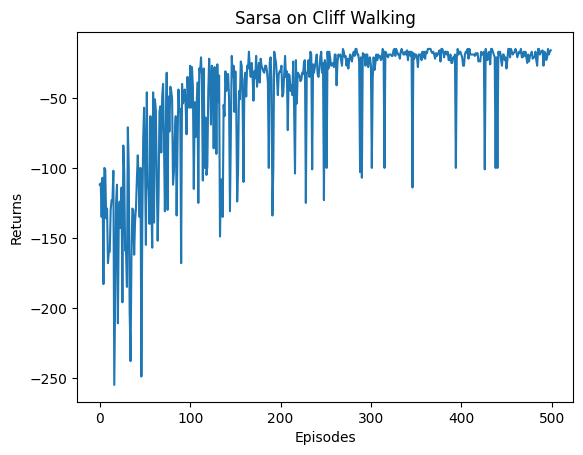

([-112,
  -111,
  -135,
  -107,
  -183,
  -100,
  -101,
  -136,
  -129,
  -168,
  -160,
  -160,
  -130,
  -123,
  -123,
  -102,
  -255,
  -188,
  -125,
  -112,
  -211,
  -135,
  -124,
  -143,
  -114,
  -196,
  -84,
  -103,
  -159,
  -160,
  -185,
  -71,
  -99,
  -202,
  -238,
  -165,
  -129,
  -130,
  -162,
  -138,
  -129,
  -108,
  -91,
  -108,
  -135,
  -100,
  -249,
  -138,
  -79,
  -57,
  -94,
  -155,
  -46,
  -109,
  -116,
  -140,
  -63,
  -128,
  -157,
  -46,
  -139,
  -51,
  -59,
  -103,
  -152,
  -120,
  -60,
  -56,
  -89,
  -49,
  -40,
  -81,
  -131,
  -78,
  -32,
  -130,
  -49,
  -74,
  -42,
  -45,
  -51,
  -112,
  -103,
  -77,
  -63,
  -134,
  -83,
  -44,
  -60,
  -58,
  -168,
  -40,
  -54,
  -50,
  -44,
  -56,
  -76,
  -35,
  -50,
  -57,
  -27,
  -57,
  -28,
  -42,
  -115,
  -53,
  -78,
  -58,
  -39,
  -125,
  -29,
  -31,
  -21,
  -41,
  -109,
  -29,
  -100,
  -64,
  -105,
  -99,
  -46,
  -22,
  -37,
  -69,
  -27,
  -32,
  -86,
  -28,
  -32,
  -90,
  -26,
  -53,
  -34,
  -1

In [32]:
ncol = 12  ##  列
nrow = 4  ##  行
env = CliffWalkingEnv(ncol, nrow)  ##  实例化悬崖环境 env
epsilon = 0.1  ##  ε的值指定是 0.1
alpha = 0.1  ##  α的值初始化是 0.1
gamma = 0.9  ##  γ的值初始化是 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)  ##  实例化sarsa


def plot_agent(agent, num_episodes=500, show=True, reset_seed=True):  # 智能体在环境中运行的序列的数量
    if reset_seed:
        np.random.seed(0)  # 注意每次生成随机数，过程一定，但依次取。因此每次运行函数需要重新设置。
    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=num_episodes // 10, desc=f'Iteration {i}') as pbar:
            for i_episode in range(num_episodes // 10):  # 每个进度条的序列数
                episode_return = 0  ##  序列返回值
                s = env.reset()  ##  初始化环境，并给出初始状态 s
                if 'Sarsa' in agent.__class__.__name__:  ##  如果是sarsa的话
                    a = agent.take_action(s)  ##  智能体采取动作，拿到初始动作actioin
                done = False  ##  是否终止的
                while not done:  ##  没有终止就执行
                    if 'Sarsa' not in agent.__class__.__name__:
                        a = agent.take_action(s)  ##  智能体采取动作，拿到初始动作actioin
                    s_, r, done = env.step(a)  ## 智能体前进一步，拿到下一个状态、奖励，是否终止的
                    # 累加回报
                    episode_return += r  # 这里回报的计算不进行折扣因子衰减
                    # 更新状态和动作
                    if 'Sarsa' in agent.__class__.__name__:
                        a_ = agent.take_action(s_)  ## 智能体使用ε-贪婪策略选择动作 a_ 
                        agent.update(s, a, r, s_, a_, done)  ##  增量更新动作价值函数
                        a = a_  ## 赋值给后续的动作
                    else:
                        # 更新Q表
                        agent.update(s, a, r, s_)
                    s = s_  ## 赋值给当前状态
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': f'{num_episodes / 10 * i + i_episode + 1}',
                        'return': f'{np.mean(return_list[-10:]):.3f}'
                    })
                pbar.update(1)

    episodes_list = list(range(len(return_list)))

    if show:
        plt.plot(episodes_list, return_list)
        plt.xlabel('Episodes')
        plt.ylabel('Returns')
        plt.title(f'{agent.__class__.__name__} on Cliff Walking')
        plt.show()

    return return_list, episodes_list


plot_agent(agent)

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 1206.19it/s, episode=50,
# return=-119.400]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 1379.84it/s, episode=100,
# return=-63.000]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 2225.14it/s, episode=150,
# return=-51.200]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 2786.80it/s, episode=200,
# return=-48.100]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 1705.21it/s, episode=250,
# return=-35.700]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 3393.12it/s, episode=300,
# return=-29.900]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 3694.32it/s, episode=350,
# return=-28.300]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 3705.87it/s, episode=400,
# return=-27.700]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 4115.61it/s, episode=450,
# return=-28.500]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3423.20it/s, episode=500,
# return=-18.900]

In [33]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    # print("Q表格：")
    # for r in range(env.nrow):
    #     for c in range(env.ncol):
    #         s = r * env.ncol + c
    #         for a in range(4):
    #             print(f'{s} {action_meaning[a]}: {agent.Q_table[s, a]:6.3f}', end='\t')
    #         print()

    for i in range(env.nrow):
        for j in range(env.ncol):
            s = i * env.ncol + j
            if s in disaster:
                print('****', end=' ')
            elif s in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(s)  ##  拿到这个状态动作价值最大的动作序列，最大的标记1，其他标记0
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# Sarsa算法最终收敛得到的策略为：
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


#### 5.4. 多步Sarsa算法

蒙特卡洛方法利用当前状态之后每一步的奖励而不使用任何价值估计，时序差分算法只利用一步奖励和下一个状态的价值估计。

多步时序差分的意思是使用步的奖励，然后使用之后状态的价值估计。

$$
\begin{align*}
Q(s_t,a_t) &\leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))\\
&\leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma r_{t+1} + ... + \gamma^n Q(s_{t+n},a_{t+n}) - Q(s_t,a_t))\\
&\leftarrow Q(s_t,a_t) + \alpha (G_t - Q(s_t,a_t))
\end{align*}
$$

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3446.77it/s, episode=500.0, return=-19.100]


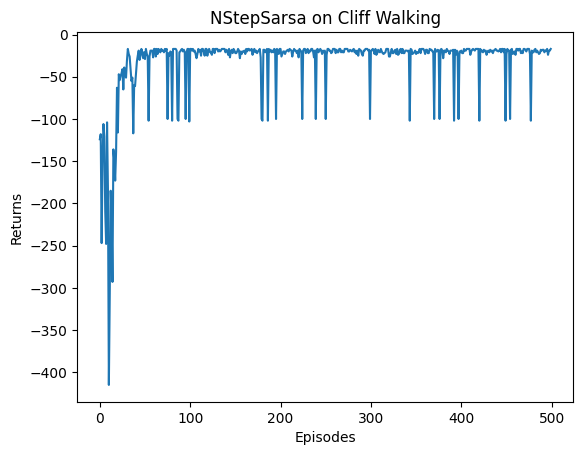

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [34]:
class NStepSarsa(Sarsa):
    """ n步Sarsa算法 """

    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4, n=1):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action, n)
        self.s_l = []  # 保存之前的状态
        self.a_l = []  # 保存之前的动作
        self.r_l = []  # 保存之前的奖励

    ## 增量更新动作价值函数，对应相应的公式
    ## s0, a0是当前时间步的
    ## r, s1, a1是下一个时间步的，r是奖励，s1是状态，a1是动作
    def update(self, s0, a0, r, s1, a1, done):
        '''        
        基于Q、r、r_、r__、Q'(a')，更新Q
        '''
        self.s_l.append(s0)  ##  当前状态s0加入到状态列表的
        self.a_l.append(a0)  ##  当前动作a0加入到动作列表的
        self.r_l.append(r)  ##  当前状态采取的动作奖励，加入到奖励列表的
        if len(self.s_l) == self.n:  # 若保存的数据可以进行n步更新
            ## 拿到下一个时间步(s1, a1)对应的动作价值函数
            G = self.Q_table[s1, a1]  # 得到Q(s_{t+n}, a_{t+n})
            ## 逆序遍历奖励列表，算多步Sarsa algorithm公式括号内的非负部分
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.r_l[i]  # 不断向前计算每一步的回报
                # 如果到达终止状态,最后几步虽然长度不够n步,也将其进行更新
                if done and i > 0:
                    s = self.s_l[i]  ## 拿出对应的状态
                    a = self.a_l[i]  ## 对应的动作
                    ## 多步sarsa，增量更新动作价值函数
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            ## 时间步往后移动，最开始的时间步内容需要删除才可以，状态、动作、奖励都需要删除
            ## 需要删除的时间步，也是需要更新的时间步，所以需要使用变量s, a来保存相应的内容以便使用
            s = self.s_l.pop(0)  # 将需要更新的状态动作从列表中删除,下次不必更新。
            a = self.a_l.pop(0)  # pop(0)是先进先出，pop(-1)是后进先出，默认是-1
            self.r_l.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])  ## 增量更新动作价值函数
        if done:  # 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.s_l = []
            self.a_l = []
            self.r_l = []


n_step = 5  # 5步Sarsa算法
agent = NStepSarsa(ncol, nrow, epsilon, alpha, gamma, n=n_step)

plot_agent(agent)
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])


# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 937.03it/s, episode=50,
# return=-26.500]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 2955.94it/s, episode=100,
# return=-35.200]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 2978.95it/s, episode=150,
# return=-20.100]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 3062.61it/s, episode=200,
# return=-27.200]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 3172.36it/s, episode=250,
# return=-19.300]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 3123.41it/s, episode=300,
# return=-27.400]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 2875.33it/s, episode=350,
# return=-28.000]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 2262.18it/s, episode=400,
# return=-36.500]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 3100.00it/s, episode=450,
# return=-27.000]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3107.54it/s, episode=500,
# return=-19.100]

# 5步Sarsa算法最终收敛得到的策略为：
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo
# ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

#### 5.5. Q-learning算法

不同于Sarsa的

$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))
$

Q-learning的更新公式是

$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma \max_{a_{t+1}} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))
$

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4154.17it/s, episode=500.0, return=-61.700]


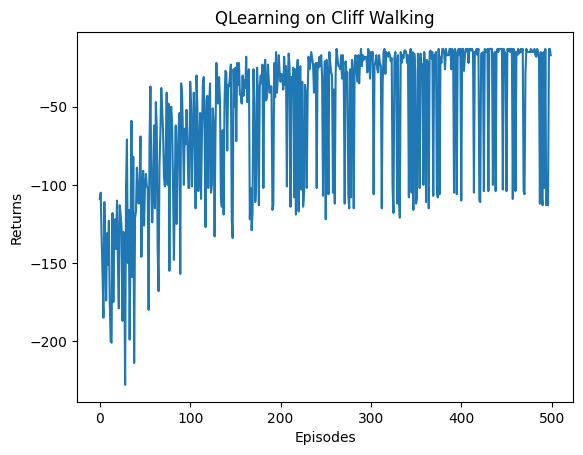

Q-learning算法最终收敛得到的策略为：
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [35]:
class QLearning(Sarsa):
    """ Q-learning算法 """

    '''
    增量更新动作价值函数，对应相应的Q-learning公式
    和sarsa algorithm不同的地方就是，这使用了状态内所有动作的最大值，但是sarsa直接使用了(s, a)状态动作对的值
    sarsa的公式就是：
    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]    ## 算时序差分的
        self.Q_table[s0, a0] += self.alpha * td_error      ##  更新动作价值函数
    '''

    def update(self, s0, a0, r, s1):
        '''
        基于Q、r、Q‘*，更新Q
        '''
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error


agent = QLearning(ncol, nrow, epsilon, alpha, gamma)

plot_agent(agent)
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 1183.69it/s, episode=50,
# return=-105.700]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 1358.13it/s, episode=100,
# return=-70.900]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 1433.72it/s, episode=150,
# return=-56.500]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 2607.78it/s, episode=200,
# return=-46.500]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 3007.19it/s, episode=250,
# return=-40.800]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 2005.77it/s, episode=300,
# return=-20.400]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 2072.14it/s, episode=350,
# return=-45.700]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 4244.04it/s, episode=400,
# return=-32.800]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 4670.82it/s, episode=450,
# return=-22.700]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4705.19it/s, episode=500,
# return=-61.700]

# Q-learning算法最终收敛得到的策略为：
# ^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

### 6. Dyna-Q算法

在每次与环境进行交互执行一次 Q-learning 之后，Dyna-Q 会做$n$次 Q-planning。其中 Q-planning 的次数$N$是一个事先可以选择的超参数，当其为 0 时就是普通的 Q-learning。值得注意的是，上述 Dyna-Q 算法是执行在一个离散并且确定的环境中，所以当看到一条经验数据$(s, a, r, s')$时，可以直接对模型做出更新，即$M(s,a)\leftarrow r, s'$。

In [36]:
# 改为从Q-learning继承，减少代码重复
class DynaQ(QLearning):
    """ Dyna-Q算法 """

    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4, n=1, n_planning=1):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action, n)

        self.n_planning = n_planning  # 执行Q-planning的次数, 对应1次Q-learning
        ## 保存历史交互的数据，也就是智能体和
        self.model = dict()  # 环境模型

    def update(self, s0, a0, r, s1):
        '''
        每步选N个s记录，基于Q、r、Q‘*，更新Q
        '''
        ## 智能体和环境交互得到的一个数据，用来update模型的
        super().update(s0, a0, r, s1)  ## 使用 智能体和环境 交互得到的 s0,a0, r, s1 来 update 动作价值函数，也就是学习 Q_table 的。
        ## 保存历史数据，也就是保存智能体和环境一次交互得到的经验数据，用来后续离线训练使用
        self.model[(s0, a0)] = r, s1  # 将数据添加到模型中
        ## 通过历史数据来训练 Q_table 动作价值函数，历史数据训练的次数是self.n_planning
        for _ in range(self.n_planning):  # Q-planning循环
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            super().update(s, a, r, s_)  ## 使用历史数据来 update Q_table

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2715.46it/s, episode=300.0, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1848.99it/s, episode=300.0, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 350.30it/s, episode=300.0, return=-13.400]


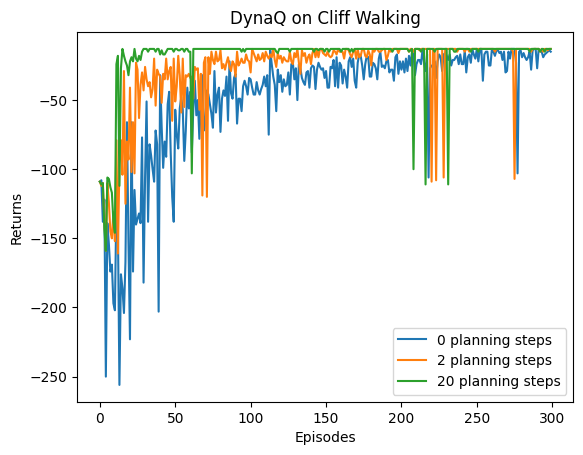

In [37]:
epsilon = 0.01
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]  ## 使用多少历史经验数据来 update 模型
for n_planning in n_planning_list:
    print(f'Q-planning步数为：{n_planning}')
    time.sleep(0.5)
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning=n_planning)
    return_list, episodes_list = plot_agent(agent, num_episodes=300, show=False, reset_seed=False)
    plt.plot(episodes_list, return_list, label=f'{n_planning} planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'{agent.__class__.__name__} on Cliff Walking')
plt.show()

# Q-planning步数为：0

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 615.42it/s, episode=30,
# return=-138.400]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 1079.50it/s, episode=60,
# return=-64.100]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 1303.35it/s, episode=90,
# return=-46.000]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 1169.51it/s, episode=120,
# return=-38.000]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 1806.96it/s, episode=150,
# return=-28.600]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 2303.21it/s, episode=180,
# return=-25.300]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 2473.64it/s, episode=210,
# return=-23.600]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 2344.37it/s, episode=240,
# return=-20.100]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 1735.84it/s, episode=270,
# return=-17.100]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2827.94it/s, episode=300,
# return=-16.500]

# Q-planning步数为：2

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 425.09it/s, episode=30,
# return=-53.800]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 655.71it/s, episode=60,
# return=-37.100]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 799.69it/s, episode=90,
# return=-23.600]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 915.34it/s, episode=120,
# return=-18.500]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 1120.39it/s, episode=150,
# return=-16.400]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 1437.24it/s, episode=180,
# return=-16.400]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 1366.79it/s, episode=210,
# return=-13.400]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 1457.62it/s, episode=240,
# return=-13.200]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 1743.68it/s, episode=270,
# return=-13.200]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1699.59it/s, episode=300,
# return=-13.500]

# Q-planning步数为：20

# Iteration 0: 100%|██████████| 30/30 [00:00<00:00, 143.91it/s, episode=30,
# return=-18.500]
# Iteration 1: 100%|██████████| 30/30 [00:00<00:00, 268.53it/s, episode=60,
# return=-13.600]
# Iteration 2: 100%|██████████| 30/30 [00:00<00:00, 274.53it/s, episode=90,
# return=-13.000]
# Iteration 3: 100%|██████████| 30/30 [00:00<00:00, 264.25it/s, episode=120,
# return=-13.500]
# Iteration 4: 100%|██████████| 30/30 [00:00<00:00, 263.58it/s, episode=150,
# return=-13.500]
# Iteration 5: 100%|██████████| 30/30 [00:00<00:00, 245.27it/s, episode=180,
# return=-13.000]
# Iteration 6: 100%|██████████| 30/30 [00:00<00:00, 257.16it/s, episode=210,
# return=-22.000]
# Iteration 7: 100%|██████████| 30/30 [00:00<00:00, 257.08it/s, episode=240,
# return=-23.200]
# Iteration 8: 100%|██████████| 30/30 [00:00<00:00, 261.12it/s, episode=270,
# return=-13.000]
# Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 213.01it/s, episode=300,
# return=-13.400]

## 强化学习进阶篇

### 7. 深度Q网络（DQN）算法

#### 7.1. 简介

DQN算法是基于Q-learning算法的深度学习算法，它的目标是解决Q-learning算法在状态动作空间较大时，无法有效学习的问题。

- 例如，当状态是一张 RGB 图像时，假设图像大小是$210*160*3$，此时一共有$256^{210*160*3}$种状态，在计算机中存储这个数量级的$Q$值表格是不现实的。更甚者，当状态或者动作连续的时候，就有无限个状态动作对，我们更加无法使用这种表格形式来记录各个状态动作对的$Q$值。

用函数拟合的方法来估计$Q$值，即将这个复杂的$Q$值表格视作数据，使用一个参数化的函数$Q_{\theta}$来拟合这些数据。

DQN 算法便可以用来解决连续状态下离散动作的问题


#### 7.2. CartPort环境

在车杆环境中，有一辆小车，智能体的任务是通过左右移动保持车上的杆竖直，若杆的倾斜度数过大，或者车子离初始位置左右的偏离程度过大，或者坚持时间到达 200 帧，则游戏结束。智能体的状态是一个维数为 4 的向量，每一维都是连续的，其动作是离散的，动作空间大小为 2。在游戏中每坚持一帧，智能体能获得分数为 1 的奖励，坚持时间越长，则最后的分数越高，坚持 200 帧即可获得最高的分数。

[CartPole-v0](https://github.com/openai/gym/wiki/CartPole-v0)

#### 7.3. DQN

不同于Sarsa的

$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))
$

Q-learning的

$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma \max_{a_{t+1}} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))
$

学习$r_t + \gamma \max_{a_{t+1}} Q(s_{t+1},a_{t+1})$来增量更新$Q(s_t,a_t)$，即使$Q(s,a)$与TD目标$r + \gamma \max_{a'} Q(s',a')$靠近。

将TD误差改为均方误差$\omega^{\ast} = \arg \min_{\omega} \mathbb{E}[(Q_{\omega}(s_i,a_i) - y_i)^2]$，其中$y_i = r_i + \gamma \max_{a'} Q_{\omega}(s^{\prime}_i,a')$。

TD目标$y$中的目标网络$Q$每C步更新一次，防止目标不断发生改变。

$\omega^{\ast} = \arg \min_{\omega} \mathbb{E}[(Q_{\omega}(s_i,a_i) - y_i)^2]$，其中$y_i = r_i + \gamma \max_{a'} Q_{\omega^-}(s^{\prime}_i,a')$。

##### 7.3.1. 经验回收

In [38]:


'''
https://zhuanlan.zhihu.com/p/656515516

强化学习的两个主要组成部分就是：
0. 智能体或者大脑；
1. 环境。环境是给定的，也就是一般由openai提供的gym库，或者gymnasium这个库。这两个库提供了很多不同的强化学习环境，可以拿来调用的，上面的悬崖环境就在gymnasium库内的，gym库已经不再update了。
智能体或者大脑：智能体根据策略或者大脑，根据环境给出的奖励reward，以及分析环境提供的状态state信息，进而给出下一步的动作action；智能体还需要能够拿到状态信息，像robot就有许许多多的传感器，来感知环境的状态信息的。
环境：环境一般是连续的不离散的，环境需要根据智能体给出的动作action做出相应的改变，还需要给出相应的奖励reward，以及状态信息state，状态信息通常是需要智能体主动获取的，当然比较简单的环境可能就直接给出了状态信息，不需要智能体主动获取。
一般环境是gymnasium库提供的内容，环境会负责step(action)前进一步的，每次根据动作前进一步或者执行一步，会返回next_state, reward, done, _，也就分别是 下一个状体、奖励、是否结束的。或者重置环境reset()。
智能体是需要program的，也就是需要人工手动program，给出策略或者深度神经网络模拟大脑，每次从环境拿到状态信息state，以及reward奖励的，智能体根据奖励以及分析拿到的状态信息，做出决策的，也就是给出动作action。
'''


class ReplayBuffer:
    ''' 
    经验回放池：最近的capacity个历史数据的保存、采样
    '''

    def __init__(self, capacity):  ## 容量的大小
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, s, a, r, s_, done):  # 将数据加入buffer
        self.buffer.append((s, a, r, s_, done))  ## 加入到队列内部，队列中的最后一个元素是最新的一个数据

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        b_P = random.sample(self.buffer, batch_size)  ## 随机采样的呢，拿到采样的历史数据。
        s, a, r, s_, done = zip(*b_P)  ## 使用zip来转置，也就是不同的自变量在不同的行
        b_s, b_a, b_r, b_s_, b_d = np.array(s), a, r, np.array(s_), done  ## 状态序列、动作序列、奖励序列、下一个状态序列，是否结束的序列
        return {'b_s': b_s, 'b_a': b_a, 'b_r': b_r, 'b_s_': b_s_, 'b_d': b_d}

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)  ##  返回历史数据的总长度

##### 7.3.2. 目标网络

In [39]:
## 构造智能体agent的大脑，也就是输入状态，返回该状态下，每个动作的动作价值
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim，
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''

    def __init__(self, s_dim, neu_dim, a_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(s_dim, neu_dim)  ## full connect层1
        self.fc2 = torch.nn.Linear(neu_dim, a_dim)  ## full connect层2

    def forward(self, x):
        '''
        前向传播：输入状态，输出动作价值
        '''
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数        
        return self.fc2(x)  # 输出层不使用激活函数，直接输出


# 8.4. Dueling DQN算法的网络
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''

    def __init__(self, s_dim, neu_dim, a_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(s_dim, neu_dim)  ## 共享网络部分
        self.fc2_A = torch.nn.Linear(neu_dim, a_dim)  ## 优势函数的
        self.fc2_V = torch.nn.Linear(neu_dim, 1)  ## 状态价值函数的

    def forward(self, x):
        A = self.fc2_A(F.relu(self.fc1(x)))  ## 优势函数
        V = self.fc2_V(F.relu(self.fc1(x)))  ## 状态价值函数
        # 残差网络的resnet，可以减去A内的均值，也可以不减的
        # Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        Q = V + (A - A.mean(dim=1, keepdim=True))  # Q值由V值和A值计算得到
        return Q

In [40]:
##  构造智能体的
class DQN:
    ''' DQN算法 '''

    def __init__(self, s_dim, neu_dim, a_dim, learning_rate, gamma, epsilon, target_lag, device, dqn_type='VanillaDQN'):
        self.a_dim = a_dim  ##  动作的dim
        ## 实例化智能体的大脑
        if dqn_type == 'DuelingDQN':
            self.q_net = VAnet(s_dim, neu_dim, a_dim).to(device)  # Q网络
            self.q_net_t = VAnet(s_dim, neu_dim, a_dim).to(device)  # 目标网络
        else:
            self.q_net = Qnet(s_dim, neu_dim, self.a_dim).to(device)  # Q网络        
            self.q_net_t = Qnet(s_dim, neu_dim, self.a_dim).to(device)  # 目标网络        
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)  # 使用Adam优化器

        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略

        self.target_lag = target_lag  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数

        self.device = device
        self.dqn_type = dqn_type  # DQN类型

    def take_action(self, s):  # epsilon-贪婪策略采取动作
        # if np.random.random() < self.epsilon * np.exp(-self.count/100):
        if np.random.random() < self.epsilon:
            a = np.random.randint(self.a_dim)  ## 随机选择一个动作
        else:
            s = torch.tensor([s], dtype=torch.float).to(self.device)  ## 状态
            a = self.q_net(s).argmax().item()  ## 智能体的大脑，根据状态拿到动作价值，q_net返回值是每个动作的动作价值，然后拿到动作的。item：tensor->int
        return a

    def max_q_value(self, s):
        '''
        返回状态s下，所有动作的动作价值Q的最大值
        '''
        s = torch.tensor([s], dtype=torch.float).to(self.device)
        return self.q_net(s).max().item()  # .item()将tensor转为标量

    ## 使用历史数据来训练智能体的大脑，两个大脑的，一个实时update做label，另一个延迟update做predict
    '''
    损失函数需要label和predict，但是强化学习是没有label的，所以需要人工构造label才行，DQN使用的构造方式是使用update步长不相同的两个Qnet，
    update数量较多的Qnet来做label，数量较少的Qnet来做predict。所以label就是使用的newest update的Qnet。相当是两个人，一个学的时间长些，
    一个学的时间短些，所以这个学习时间更长的人，可以当老师了，学习时间短的人，就只能当学生了。老师可以教导学生的。所以两个大脑模型Qnet，
    一个做老师，一个是学生，也就是一个label另一个则是predict。这样就构造出了相应的label。
    target_q_net使用下一个状态，然后Q-learning来predict当前(状态，动作)的动作价值，predict
    q_net使用当前状态和动作，直接算出当前(状态，动作)的动作价值，label
    '''

    def update(self, d_P):
        '''
        基于一批Q、s、a、r、s_、done、Q（老）'*，更新Q
        '''
        ## 初始化 状态、动作、奖励、下一个状态、是否结束的
        b_s = torch.tensor(d_P['b_s'], dtype=torch.float).to(self.device)  # (64, 4)
        b_a = torch.tensor(d_P['b_a']).view(-1, 1).to(self.device)  # (64, 1)
        b_r = torch.tensor(d_P['b_r'], dtype=torch.float).view(-1, 1).to(self.device)  # (64, 1)
        b_s_ = torch.tensor(d_P['b_s_'], dtype=torch.float).to(self.device)  # (64, 4)
        b_d = torch.tensor(d_P['b_d'], dtype=torch.float).view(-1, 1).to(self.device)  # (64, 1)

        ## target, 因该网络实时update，所以可以看作是真实值，也就是监督学习内的label，而目标网络延迟很多，目标网络的输出可以看作predict
        ## “真实”label，q_net输入当前的状态，返回值是当前状态下每个动作的动作价值，所以gather以后拿到的是：当前(状态和动作)对应的动作价值
        b_q = self.q_net(b_s).gather(1, b_a)  # Q值。gather传入的两个参数位：dim, index。
        # 因为q_net(b_s)返回的维度(batch_size=64, a_dim=2)，gather(1, b_a)后的维度是(batch_size=64, 1)
        # 下个状态的最大Q值，延迟网络的输出
        ## 可以看作是predict，输入是下一个状态，返回值是下一个状态所有动作的动作价值内的最大值
        ## 用来算当前(状态和动作)下的动作价值
        ## Q-learning algorithm，算出的是当前(状态和动作)的动作价值    
        if self.dqn_type == 'DoubleDQN':
            b_a_ = self.q_net(b_s_).max(1)[1].view(-1, 1)  # 选择最佳动作
            b_rq_ = b_r + self.gamma * self.q_net_t(b_s_).gather(1, b_a_) * (1 - b_d)  # TD目标
        else:
            b_rq_ = b_r + self.gamma * self.q_net_t(b_s_).max(1)[0].view(-1, 1) * (1 - b_d)  ## TD目标。

        # self.q_net_t(b_s_)的维度是(batch_size, a_dim)，max(1)后是(batch_size, 1)，max(1)[0]后是(batch_size,)，view(-1, 1)后是(batch_size, 1)
        # self.q_net(b_s): torch.Size([64, 2]) type: <class 'torch.Tensor'>
        # self.q_net(b_s).gather(1, b_a): torch.Size([64, 1]) type: <class 'torch.Tensor'>
        # max(1)返回的是torch.return_types.max，有两个属性，indices和values，indices是最大值的索引，values是最大值，[0]取出values
        # self.q_net_t(b_s_).max(1)[0]: torch.Size([64]) type: <class 'torch.Tensor'>
        # self.q_net_t(b_s_).max(1)[0].view(-1, 1): torch.Size([64, 1]) type: <class 'torch.Tensor'>    

        ## q_net的truth label 和 target_q_net的predict，算损失用来反向传播
        ## 也就是两个网络算出来的（状态和动作）对应的动作价值，用MSE来算损失函数的
        dqn_loss = torch.mean(F.mse_loss(b_q, b_rq_))  # 均方误差损失函数。TD误差
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  ##  反向传播求出梯度
        self.optimizer.step()  ##  使用累加的梯度来update参数

        if self.count % self.target_lag == 0:  ##  达到了给定的步长，复制最newest的参数给target_q_net网络，q_net是label，target_q_net是predict
            self.q_net_t.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

#### 7.4. DQN代码实践

In [41]:
lr = 2e-3
num_episodes = 500
neu_dim = 128
gamma = 0.98
epsilon = 0.01
target_lag = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
random.seed(0)
np.random.seed(0)
gym.utils.seeding.np_random(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
s_dim = env.observation_space.shape[0]  # (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
a_dim = env.action_space.n  # 动作的维度
agent = DQN(s_dim, neu_dim, a_dim, lr, gamma, epsilon, target_lag, device)

return_list = []
allimage = []
for i in range(10):
    ## 训练的次数是
    with tqdm(total=int(num_episodes / 10), desc=f'Iteration {i}') as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0  ## 累积的奖励
            s = env.reset()  ## 环境随机重置的

            if len(s) != 2 * 2:
                s = s[0]
            done = False
            # https://huggingface.co/learn/deep-rl-course/unit4/hands-on#create-a-virtual-display
            while not done:
                if (i_episode + 1) % 10 == 0 and i in [9]:  # 最后一次iteration，隔10次episode渲染
                    img = env.render()
                    allimage.append(img)
                # cv2.imshow("CartPole-v1", img)
                # cv2.waitKey(-1)

                a = agent.take_action(s)  ## 拿到动作价值最大的动作，取值可选值是：0 或者 1
                ## 环境根据动作，前进一步的，拿到下一个状态，奖励，是否终止，是否步长太长，info
                s_, r, terminated, truncated, info = env.step(a)
                done = terminated | truncated  ## 终止或者步长太长，都会导致已经结束
                ## 将状态、动作、奖励、下一个状态、是否结束，加入到缓冲池，也就是历史内，用来训练大脑网络的
                replay_buffer.add(s, a, r, s_, done)
                s = s_  ## 下一个状态赋值到当前状态
                episode_return += r  ##累加奖励的
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:  ## 不停的和环境交互，直到缓冲池内的历史数据大于一定的数量，再开始训练网络的
                    ## 从缓冲池采样历史数据，用来训练大脑网络的
                    d_P = replay_buffer.sample(batch_size)  ##  拿到的历史数据
                    agent.update(d_P)  ## 训练大脑网络 q_net
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': f'{num_episodes / 10 * i + i_episode + 1}',
                    'return': f'{np.mean(return_list[-10:]):.3f}'
                })
            pbar.update(1)

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 764.86it/s, episode=50,
# return=9.300]
# Iteration 1: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s, episode=100,
# return=12.300]
# Iteration 2: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s, episode=150,
# return=123.000]
# Iteration 3: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it, episode=200,
# return=153.600]
# Iteration 4: 100%|██████████| 50/50 [01:30<00:00,  1.80s/it, episode=250,
# return=180.500]
# Iteration 5: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it, episode=300,
# return=185.000]
# Iteration 6: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, episode=350,
# return=193.900]
# Iteration 7: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it, episode=400,
# return=196.600]
# Iteration 8: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, episode=450,
# return=193.800]
# Iteration 9: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, episode=500,
# return=200.000]

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_44864\1456780963.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  s = torch.tensor([s], dtype=torch.float).to(self.device)  ## 状态
Iteration 9: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it, episode=500.0, return=245.100]


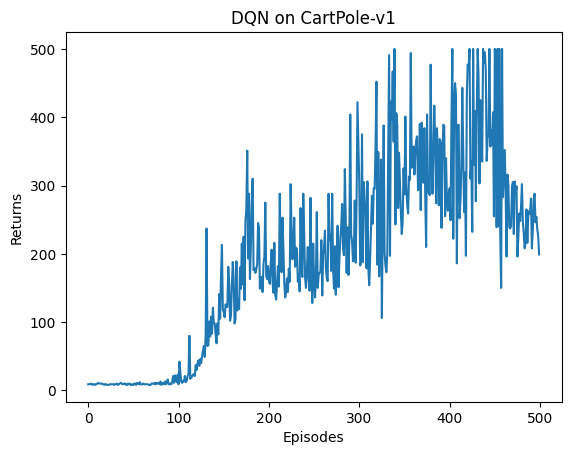

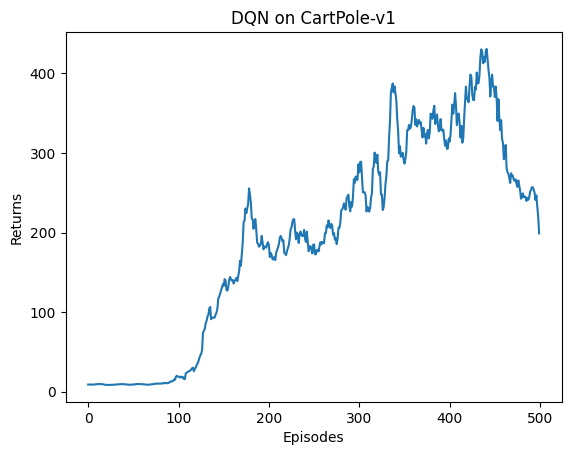

In [42]:
#https://github.com/guicalare/Img2gif/blob/master/Code/Img2Gif.py
imageio.mimsave(r'chapter7.gif', allimage, duration=10)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'DQN on {env_name}')
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'DQN on {env_name}')
plt.show()

#### 7.5. 以图像为输入的DQN算法

In [43]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''

    def __init__(self, a_dim, in_channels=4):
        super().__init__()
        # 初始化卷积层
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # 初始化全连接层
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        # 初始化输出层
        self.head = torch.nn.Linear(512, a_dim)

    def forward(self, x):
        # 将输入归一化到[0,1]
        x = x / 255
        # 激活函数ReLU
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        # 输出层不需要激活函数
        return self.head(x)

### 8. DQN改进算法

#### 8.2. Double DQN

普通的 DQN 算法通常会导致对$Q$值的过高估计（overestimation）

$$
\begin{aligned}
y_i &= r_i + \gamma \max_{a'} Q_{\omega^-}(s^{\prime}_i,a')\\
&= r_i + \gamma Q_{\omega^-}(s^{\prime}_i, \arg \max_{a'} Q_{\omega^-}(s^{\prime}_i,a'))\\
&> r_i + \gamma Q_{\omega^-}(s^{\prime}_i, \arg \max_{a'} Q_{\omega}(s^{\prime}_i,a'))
\end{aligned}
$$

#### 8.3. Doubel DQN代码实践

本节采用的环境是倒立摆（Inverted Pendulum），该环境下有一个处于随机位置的倒立摆，如图 8-1 所示。环境的状态包括倒立摆角度的正弦值$sin(\theta)$，余弦值$cos(\theta)$，角速度$\dot{\theta}$；动作为对倒立摆施加的力矩，详情参见表 8-1 和表 8-2。每一步都会根据当前倒立摆的状态的好坏给予智能体不同的奖励，该环境的奖励函数为$-(\theta^2 + 0.1 \cdot \dot{\theta}^2 + 0.001 \cdot action^2)$，倒立摆向上保持直立不动时奖励为 0，倒立摆在其他位置时奖励为负数。环境本身没有终止状态，运行 200 步后游戏自动结束。

力矩大小是在$[-2, 2]$的范围内的连续值。由于 DQN 只能处理离散动作环境，因此我们无法直接用 DQN 来处理倒立摆环境，但倒立摆环境可以比较方便地验证 DQN 对$Q$值的过高估计：倒立摆环境下$Q$值的最大估计应为 0（倒立摆向上保持直立时能选取的最大值），$Q$值出现大于 0 的情况则说明出现了过高估计。为了能够应用 DQN，我们采用离散化动作的技巧。例如，下面的代码将连续的动作空间离散为 11 个动作。动作$[0, 1, 2, ..., 10]$分别代表力矩为$[-2, -1.6, -1.2, ..., 2]$。

In [44]:
lr = 1e-2
num_episodes = 200
neu_dim = 128
gamma = 0.98
epsilon = 0.01
target_lag = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
s_dim = env.observation_space.shape[0]
a_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, a_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action / (a_dim - 1)) * (action_upbound - action_lowbound)

In [45]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    allimage = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc=f'Iteration {i}') as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0  ## 累积的奖励
                s = env.reset()  ## 环境随机重置的
                if len(s) != 3:
                    s = s[0]
                done = False
                # https://huggingface.co/learn/deep-rl-course/unit4/hands-on#create-a-virtual-display
                while not done:
                    if (i_episode + 1) % 10 == 0 and i in [9]:
                        img = env.render()
                        allimage.append(img)
                    # cv2.imshow("CartPole-v1", img)
                    # cv2.waitKey(-1)
                    a = agent.take_action(s)  ## 拿到动作价值最大的动作，取值可选值是11个
                    max_q_value = agent.max_q_value(s) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(a, env, agent.a_dim)  ## 离散值到continuous的值
                    # s_, r, done, _ = env.step([action_continuous])
                    ## 环境根据动作，前进一步的，拿到下一个状态，奖励，是否终止，是否步长太长，info
                    s_, r, terminated, truncated, info = env.step([action_continuous])
                    done = terminated | truncated  ## 终止或者步长太长，都会导致已经结束
                    ## 将状态、动作、奖励、下一个状态、是否结束，加入到缓冲池，也就是历史内，用来训练大脑网络的
                    replay_buffer.add(s, a, r, s_, done)
                    s = s_  ## 下一个状态赋值到当前状态
                    episode_return += r  ##累加奖励的
                    if replay_buffer.size() > minimal_size:
                        d_P = replay_buffer.sample(batch_size)
                        agent.update(d_P)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': f'{num_episodes / 10 * i + i_episode + 1}',
                        'return': f'{np.mean(return_list[-10:]):.3f}'
                    })
                pbar.update(1)
    return return_list, max_q_value_list, allimage

Iteration 9: 100%|██████████| 20/20 [00:20<00:00,  1.00s/it, episode=200.0, return=-189.009]


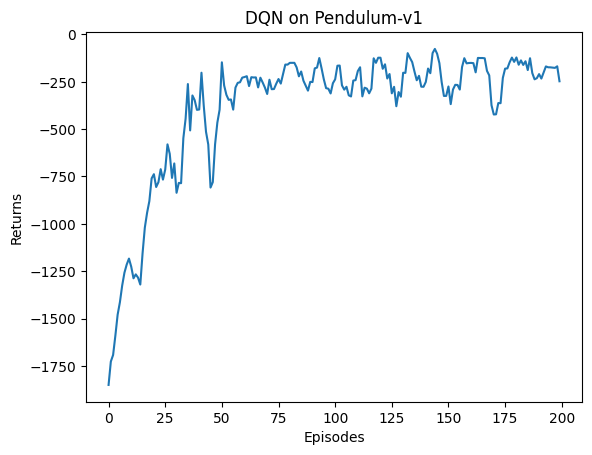

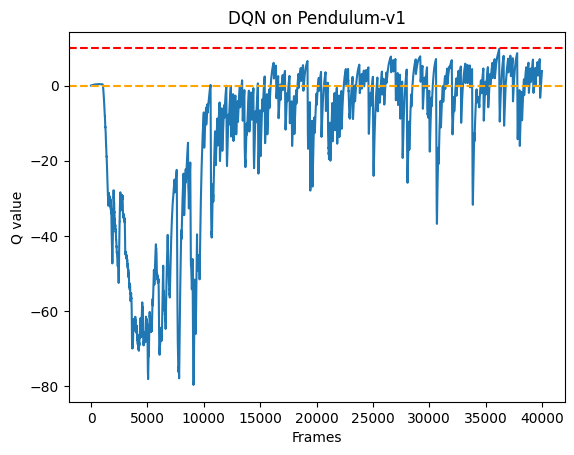

In [46]:
random.seed(0)
np.random.seed(0)
# _ = env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)  ## 实例化缓冲池也就是历史数据
agent = DQN(s_dim, neu_dim, a_dim, lr, gamma, epsilon, target_lag, device)
return_list, max_q_value_list, allimage = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

# https://github.com/guicalare/Img2gif/blob/master/Code/Img2Gif.py
imageio.mimsave(r'chapter8_0.gif', allimage, duration=10)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'DQN on {env_name}')
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title(f'DQN on {env_name}')
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s, episode=200.0, return=-302.872]


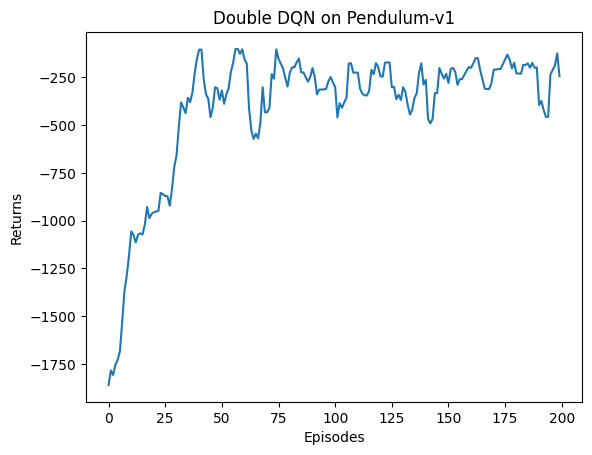

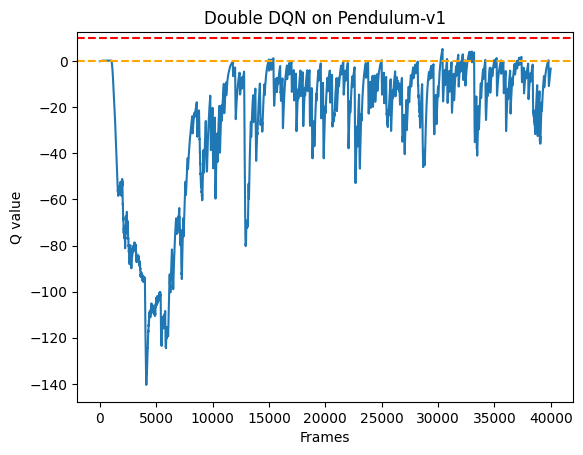

In [47]:
random.seed(0)
np.random.seed(0)
# _ = env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)  ## 实例化缓冲池也就是历史数据
agent = DQN(s_dim, neu_dim, a_dim, lr, gamma, epsilon, target_lag, device, 'DoubleDQN')
return_list, max_q_value_list, allimage = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

# https://github.com/guicalare/Img2gif/blob/master/Code/Img2Gif.py
imageio.mimsave(r'chapter8_1.gif', allimage, duration=10)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'Double DQN on {env_name}')
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title(f'Double DQN on {env_name}')
plt.show()


#### 8.4. Dueling DQN

将状态动作价值函$Q$数减去状态价值函数$V$的结果定义为优势函数$A$，即$A(s,a) = Q(s,a) - V(s)$。

$$
\begin{aligned}
Q_{\eta,\alpha,\beta}(s,a) &= V_{\eta,\alpha}(s) + A_{\eta,\beta}(s,a)\\
&= V_{\eta,\alpha}(s) + A_{\eta,\beta}(s,a) - \max_{a'} A_{\eta,\beta}(s,a')\\
&= V_{\eta,\alpha}(s) + (A_{\eta,\beta}(s,a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A_{\eta,\beta}(s,a'))
\end{aligned}
$$

存在对于$V$值和$A$值建模不唯一性的问题。例如，对于同样的$Q$值，如果将$V$值加上任意大小的常数$C$，再将所有值减去$C$，则得到的$Q$值依然不变，这就导致了训练的不稳定性。

第二行：减去$A$的最大值

第三行：减去$A$的均值

每一次更新时，函数$V$都会被更新，这也会影响到其他动作的$Q$值。而传统的 DQN 只会更新某个动作的$Q$值，其他动作的$Q$值就不会更新。因此，Dueling DQN 能够更加频繁、准确地学习状态价值函数。

[跳转到模型代码](#732-目标网络)

Iteration 9: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it, episode=200.0, return=-186.064]


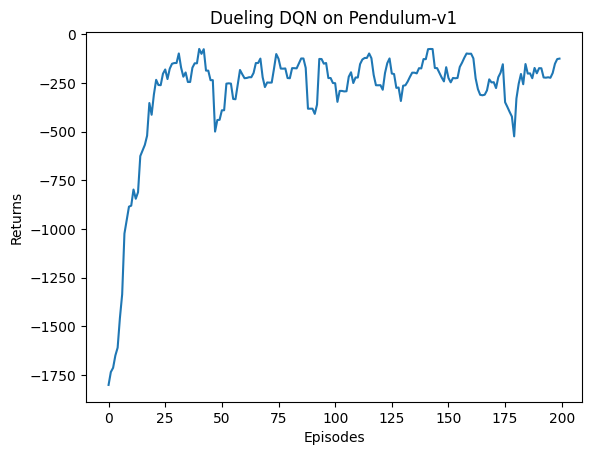

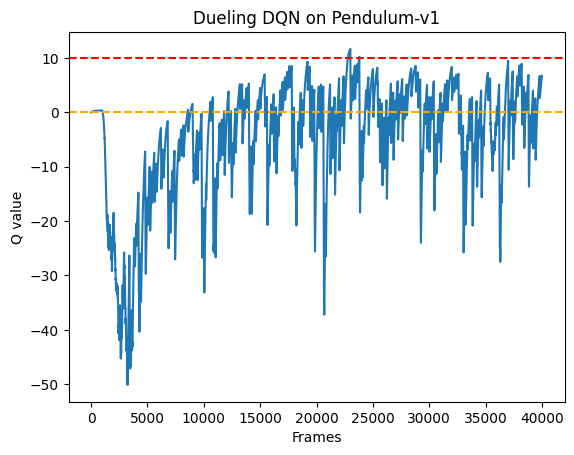

In [48]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)  ## 实例化缓冲池也就是历史数据
agent = DQN(s_dim, neu_dim, a_dim, lr, gamma, epsilon, target_lag, device, 'DuelingDQN')
return_list, max_q_value_list, allimage = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

# https://github.com/guicalare/Img2gif/blob/master/Code/Img2Gif.py
imageio.mimsave(r'chapter8_2.gif', allimage, duration=10)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'Dueling DQN on {env_name}')
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title(f'Dueling DQN on {env_name}')
plt.show()

### 9. 策略梯度算法

#### 9.2. 策略梯度

策略梯度算法的目标是直接优化策略$\pi_{\theta}(a|s)$，而不是优化状态动作价值函数$Q(s,a)$。

为策略函数建模，输入某个状态，然后输出一个动作的概率分布。目标是要寻找一个最优策略并最大化这个策略在环境中的期望回报$J(\theta)$，即

$$
J(\theta) = \mathbb{E}_{s_0}[V^{\pi_{\theta}}(s_0)]
$$

其中，$s_0$表示初始状态。现在有了目标函数，我们将目标函数对策略$\theta$求导，得到导数后，就可以用梯度上升方法来最大化这个目标函数，从而得到最优策略。

策略$\pi$下的状态访问分布$\nu^{\pi}(s)$定义为在策略$\pi$下，状态$s$被访问的概率。状态访问分布$\nu^{\pi}(s)$可以通过状态转移矩阵和初始状态分布计算得到。

对目标函数求梯度（$\propto$表示正比于）:

$$
\begin{aligned}
\nabla_{\theta} J(\theta) &\propto \sum_{s \in \mathcal{S}} \nu^{\pi_{\theta}}(s) \sum_{a \in \mathcal{A}} Q^{\pi_{\theta}}(s,a) \nabla_{\theta} \pi_{\theta}(a|s)\\
&= \sum_{s \in \mathcal{S}} \nu^{\pi_{\theta}}(s) \sum_{a \in \mathcal{A}} \pi_{\theta}(a|s) Q^{\pi_{\theta}}(s,a) \frac{\nabla_{\theta} \pi_{\theta}(a|s)}{\pi_{\theta}(a|s)}\\
&= \mathbb{E}_{s \sim \nu^{\pi_{\theta}}, a \sim \pi_{\theta}}[Q^{\pi_{\theta}}(s,a) \nabla_{\theta} \log \pi_{\theta}(a|s)]
\end{aligned}
$$

其中，$Q^{\pi_{\theta}}(s,a)$表示在策略$\pi_{\theta}$下状态动作价值函数的期望值，$\nabla_{\theta} \log \pi_{\theta}(a|s)$表示策略$\pi_{\theta}$的梯度。

#### 9.3. REINFORCE算法

采用蒙特卡洛方法估计$Q^{\pi_{\theta}}(s,a)$，即

$$
Q^{\pi_{\theta}}(s,a) = \sum_{t=0}^{T} (\sum_{t'=t}^{T} \gamma^{t'-t} r_{t'})
$$

其中，$T$表示一个episode的最大长度，$r_t$表示在时刻$t$的奖励，$\gamma$表示折扣因子。

In [49]:
## 构造智能体 agent 的大脑，也就是输入状态，返回该状态下，选择每个动作的概率
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim
class PolicyNet(Qnet):
    def forward(self, x):
        return F.softmax(super().forward(x), dim=1)  ## 返回该状态下，选择的动作的概率

In [50]:
## 策略梯度算法
## 智能体
class REINFORCE:
    def __init__(self, s_dim, neu_dim, a_dim, learning_rate, gamma, device):
        ## 实例化智能体的大脑
        self.policy_net = PolicyNet(s_dim, neu_dim, a_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, s):  # 根据动作概率分布随机采样
        s = torch.tensor([s], dtype=torch.float).to(self.device)
        pi_s = self.policy_net(s)  ## 拿到该状态下，每个动作的选择概率
        a_dist = torch.distributions.Categorical(pi_s)  ##   配置 好采样的概率
        a = a_dist.sample()  ## 对该状态下，所有的动作采样，采样的概率是probs
        return a.item()  ## 返回依概率采样得到的动作

    ## 训练策略网络的，用一条序列来训练
    def update(self, transition_dict):
        '''
        基于已经历的所有r，更新Q，再基于Q计算V的梯度，从而更新pi
        '''
        ## 拿到这条序列内的 奖励、状态和动作
        R = transition_dict['R']
        S = transition_dict['S']
        A = transition_dict['A']

        Q = 0  ##   初始化回报值 = 0
        self.optimizer.zero_grad()  ## 所有参数的梯度置0
        for i in reversed(range(len(R))):  # 从最后一步算起
            r = R[i]  ##  拿到这一步的奖励
            s = torch.tensor([S[i]], dtype=torch.float).to(self.device)  ##  拿到这一步的状态
            a = torch.tensor([A[i]]).view(-1, 1).to(self.device)  ##  拿到这一步的动作
            pi_sa = self.policy_net(s).gather(1, a)  ## 在状态s下，动作a的概率
            Q = self.gamma * Q + r  ## 算这一步状态s的回报
            # 算动作概率的log值
            loss = -torch.log(pi_sa) * Q  # 每一步的损失函数             ##  算这一步的动作回报，并取相反数的
            loss.backward()  # 反向传播计算梯度 ## 梯度会累加的
        self.optimizer.step()  # 梯度下降 update 参数 ## 所以一个序列以后，网络 policy_net 的参数才会 update

In [51]:
learning_rate = 1e-3
num_episodes = 1000
neu_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v1"
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
torch.manual_seed(0)
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.n
agent = REINFORCE(s_dim, neu_dim, a_dim, learning_rate, gamma, device)

return_list = []
allimage = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc=f'Iteration {i}') as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'S': [], 'A': [], 'S_': [], 'R': [], 'dones': []}
            s = env.reset()
            if len(s) != 2 * 2:
                s = s[0]
            done = False
            ## 采样一条序列的
            while not done:
                if (i_episode + 1) % 10 == 0 and i in [9]:
                    img = env.render()
                    allimage.append(img)
                # cv2.imshow("CartPole-v1", img)
                # cv2.waitKey(-1)
                a = agent.take_action(s)  ##  根据状态采取动作的
                ##  环境执行动作，并反馈下一个状态、动作的奖励、是否完成、步长太长的，info
                s_, r, terminated, truncated, info = env.step(a)
                done = terminated | truncated  ## 终止或者步长太长，都会导致已经结束
                ## record该序列的 该时刻状态、该时刻动作、下一个状态、动作的奖励、是否完成的
                transition_dict['S'].append(s)
                transition_dict['A'].append(a)
                transition_dict['S_'].append(s_)
                transition_dict['R'].append(r)
                transition_dict['dones'].append(done)
                s = s_  ## 下一个状态赋值到当前状态
                episode_return += r  ##累加奖励的
            return_list.append(episode_return)
            agent.update(transition_dict)  ## 训练策略网络的，用一条序列来训练
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': f'{num_episodes / 10 * i + i_episode + 1}',
                    'return': f'{np.mean(return_list[-10:]):.3f}'
                })
            pbar.update(1)
imageio.mimsave(r'chapter9.gif', allimage, duration=10)

# Iteration 0: 100%|██████████| 100/100 [00:04<00:00, 23.88it/s, episode=100,
# return=55.500]
# Iteration 1: 100%|██████████| 100/100 [00:08<00:00, 10.45it/s, episode=200,
# return=75.300]
# Iteration 2: 100%|██████████| 100/100 [00:16<00:00,  4.75it/s, episode=300,
# return=178.800]
# Iteration 3: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s, episode=400,
# return=164.600]
# Iteration 4: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s, episode=500,
# return=156.500]
# Iteration 5: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s, episode=600,
# return=187.400]
# Iteration 6: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s, episode=700,
# return=194.500]
# Iteration 7: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s, episode=800,
# return=200.000]
# Iteration 8: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s, episode=900,
# return=200.000]
# Iteration 9: 100%|██████████| 100/100 [00:22<00:00,  4.14it/s, episode=1000,
# return=186.100]

Iteration 9: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s, episode=1000.0, return=148.100]


REINFORCE on CartPole-v1


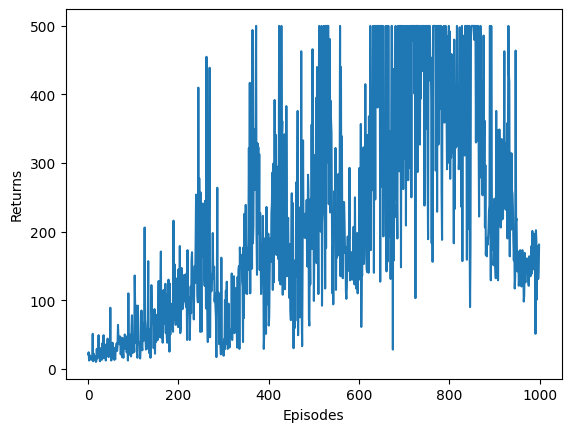

REINFORCE on CartPole-v1


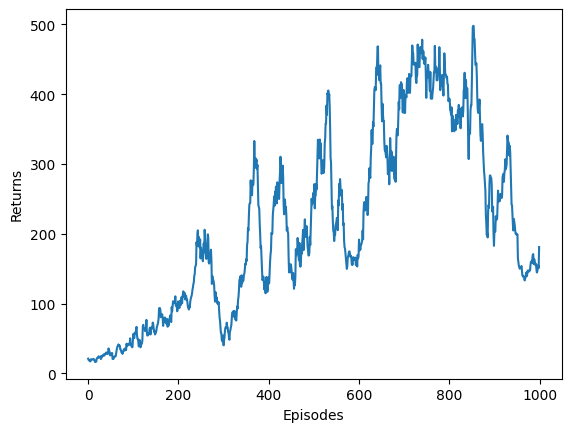

In [52]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
print(f'{agent.__class__.__name__} on {env_name}')
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
print(f'{agent.__class__.__name__} on {env_name}')
plt.show()

#### 9.5. 小结

从交互中学习，并且其优化的目标（即策略期望回报）正是最终所使用策略的性能，这比基于价值的强化学习算法的优化目标（一般是时序差分误差的最小化）要更加直接。 REINFORCE 算法理论上是能保证局部最优的，它实际上是借助蒙特卡洛方法采样轨迹来估计动作价值，这种做法的一大优点是可以得到无偏的梯度。但是，正是因为使用了蒙特卡洛方法，REINFORCE 算法的梯度估计的方差很大，可能会造成一定程度上的不稳定，这也是第 10 章将介绍的 Actor-Critic 算法要解决的问题。

#### 9.6. 策略梯度证明

$$
\begin{aligned}
\nabla_\theta V^{\pi_\theta}(s) &= \nabla_\theta\left(\sum_{a\in A} \pi_\theta(a|s) Q^{\pi_\theta}(s,a)\right) \\
&=  \sum_{a\in A} \left(\nabla_\theta \pi_\theta(a|s) Q^{\pi_\theta}(s, a) + \pi_\theta(a|s)\nabla_\theta Q^{\pi_\theta}(s, a)\right) \\
&=  \sum_{a\in A} \left(\nabla_\theta \pi_\theta(a|s) Q^{\pi_\theta}(s, a) + \pi_\theta(a|s)\nabla_\theta \sum_{s',r} p(s',r|s,a)(r + \gamma V^{\pi_\theta}(s'))\right) \\
&=  \sum_{a\in A} \left(\nabla_\theta \pi_\theta(a|s) Q^{\pi_\theta}(s, a) + \gamma \pi_\theta(a|s) \sum_{s'} p(s',r|s,a)\nabla_\theta V^{\pi_\theta}(s')\right) \\
&=  \sum_{a\in A} \left(\nabla_\theta \pi_\theta(a|s) Q^{\pi_\theta}(s, a) + \gamma \pi_\theta(a|s) \sum_{s'} p(s'|s,a) \nabla_\theta V^{\pi_\theta}(s')\right)
\end{aligned}
$$

为了简化表示，我们让$\phi(s) = \sum_{a\in A} \nabla_\theta \pi_\theta(a|s)Q^{\pi_\theta}(s, a)$, 定义$d^{\pi_\theta}(s \to x, k)$为策略$\pi$从状态$s$出发$k$步后到达状态$x$的概率。我们继续推导：

$$
\begin{aligned}
\nabla_\theta V^{\pi_\theta}(s) &= \phi(s) + \gamma \sum_a \pi_\theta(a|s) \sum_{s'} p(s'|s, a) \nabla_\theta V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma \sum_{s'} \sum_a \pi_\theta(a|s) p(s'|s, a) \nabla_\theta V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma \sum_{s'} d^{\pi_\theta}(s \to s', 1) \nabla_\theta V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma \sum_{s'} d^{\pi_\theta}(s \to s', 1)[\phi(s') + \gamma \sum_{s''} d^{\pi_\theta}(s' \to s'', 1)\nabla_\theta V^{\pi_\theta}(s'')]\\
&= \phi(s) + \gamma \sum_{s'} d^{\pi_\theta}(s \to s', 1)[\phi(s') + \gamma^2 \sum_{s''} d^{\pi_\theta}(s' \to s'', 2)\nabla_\theta V^{\pi_\theta}(s'')]\\
&= \phi(s) + \gamma \sum_{s'} d^{\pi_\theta}(s \to s', 1)[\phi(s') + \gamma^2 \sum_{s''} d^{\pi_\theta}(s' \to s'', 2)\phi(s'') + \gamma^3 \sum_{s'''} d^{\pi_\theta}(s'' \to s''', 3)\nabla_\theta V^{\pi_\theta}(s''')]\\
&= \cdots\\
&= \sum_{x \in \mathcal{S}} \sum_{k=0}^{\infty} \gamma^k d^{\pi_\theta}(s \to x, k)\phi(x)
\end{aligned}
$$

定义$\eta(s) = \mathbb{E}_{s_0}\left[\sum_{k=0}^{\infty}\gamma^k d^{\pi_\theta}(s_0 \rightarrow s, k)\right]$。至此，回到目标函数：

$$
\begin{aligned}
\nabla_\theta J(\theta) &= \nabla_\theta \mathbb{E}_{s_0}[V^{\pi_\theta}(s_0)]\\
&= \sum_s \mathbb{E}_{s_0}\left[\sum_{k=0}^{\infty}\gamma^k d^{\pi}(s_0 \rightarrow s, k)\right]\phi(s)\\
&= \sum_s \eta(s)\phi(s)\\
&= \left(\sum_s \eta(s)\right) \sum_s \frac{\eta(s)}{\sum_s \eta(s)}\phi(s)\\
&\propto \sum_s \frac{\eta(s)}{\sum_s \eta(s)}\phi(s)\\
&= \sum_s v^{\pi_\theta}(s)\sum_a Q^{\pi_\theta}(s, a)\nabla_\theta \pi_\theta(a|s)
\end{aligned}
$$

### 10. Actor-Critic算法

#### 10.1. 简介

 基于值函数的方法DQN：dqn_loss = torch.mean(F.mse_loss(b_q, b_rq_))
 
 基于策略的方法REINFORCE：loss = -torch.log(pi_sa) * Q = -torch.log(self.policy_net(s).gather(1, a)) * (self.gamma * Q + r)
 
 Actor-Critic算法结合了两种方法，既学习值函数，又学习策略函数
 
#### 10.2. Actor-Critic

REINFORCE中的梯度写成更一般的形式：
$$
\begin{aligned}
\nabla_{\theta} J(\theta) &\propto \mathbb{E}_{s \sim \nu^{\pi_{\theta}}, a \sim \pi_{\theta}}[Q^{\pi_{\theta}}(s,a) \nabla_{\theta} \log \pi_{\theta}(a|s)]\\
&= \mathbb{E}_{s \sim \nu^{\pi_{\theta}}, a \sim \pi_{\theta}}\left[ \sum_{t=0}^{T} \psi_t \nabla_\theta \log \pi_\theta (a_t | s_t) \right]
\end{aligned}
$$

采用蒙特卡洛方法估计$Q^{\pi_{\theta}}(s,a)$，即

$$
Q^{\pi_{\theta}}(s,a) = \sum_{t=0}^{T} (\sum_{t'=t}^{T} \gamma^{t'-t} r_{t'})
$$

其中，$\psi_t$ 可以有很多种形式：

1. $\sum_{t'=0}^{T} \gamma^{t'} r_{t'}$：轨迹的总回报；
2. $\sum_{t'=t}^{T} \gamma^{t'-t} r_{t'}$：动作 $a_t$ 之后的回报，即REINFORCE；
3. $\sum_{t'=t}^{T} \gamma^{t'-t} r_{t'} - b(s_t)$：基准线版本的改进；
4. $Q^{\pi_\theta}(s_t, a_t)$：动作价值函数；
5. $A^{\pi_\theta}(s_t, a_t)$：优势函数；
6. $r_t + \gamma V^{\pi_\theta}(s_{t+1}) - V^{\pi_\theta}(s_t)$：时序差分残差。

9.5 节提到 REINFORCE 通过蒙特卡洛采样的方法对策略梯度的估计是无偏的，但是方差非常大。我们可以用形式(3)引入基线函数（baseline function）$b(s_t)$来减小方差。此外，我们也可以采用 Actor-Critic 算法估计一个动作价值函数$Q$，代替蒙特卡洛采样得到的回报，这便是形式(4)。这个时候，我们可以把状态价值函数$V$作为基线，从$Q$函数减去这个$V$函数则得到了函数，我们称之为**优势函数**（advantage function），这便是形式(5)。更进一步，我们可以利用等式$Q=r+\gamma V$得到形式(6)。

本章将着重介绍形式(6)，即通过时序差分残差$r_t + \gamma V^{\pi_\theta}(s_{t+1}) - V^{\pi_\theta}(s_t)$来指导策略梯度进行学习。
用$Q$值或者$V$值本质上也是用奖励来进行指导。REINFORCE 算法基于蒙特卡洛采样，只能在序列结束后进行更新，这同时也要求任务具有有限的步数，而 Actor-Critic 算法则可以在每一步之后都进行更新，并且不对任务的步数做限制。

Actor-Critic 分为两个部分：Actor（策略网络）和 Critic（价值网络）
- Actor （厨师）要做的是与环境交互，并在 Critic 价值函数的指导下用策略梯度学习一个更好的策略。
    - 更新采用策略梯度的原则
- Critic （试菜员）要做的是通过 Actor 与环境交互收集的数据学习一个价值函数，这个价值函数会用于判断在当前状态什么动作是好的，什么动作不是好的，进而帮助 Actor 进行策略更新。
    -  采取时序差分残差的学习方式
        - 时序差分目标td_target：$r_t + \gamma V^{\pi_\theta}(s_{t+1})$
        - 价值函数的损失函数：$$\begin{aligned} \mathcal{L} &= \frac{1}{2} \left( r + \gamma V_\omega(s_{t+1}) - V_\omega(s_t) \right)^2\\
                 \nabla_\omega \mathcal{L}(\omega) &= - \left( r + \gamma V_\omega(s_{t+1}) - V_\omega(s_t) \right) \nabla_\omega V_\omega(s_t) \end{aligned}$$


In [67]:
## 构造智能体 agent 的大脑，也就是输入状态，返回该状态下，每个动作的动作价值
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim
class ValueNet(torch.nn.Module):
    def __init__(self, s_dim, neu_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(s_dim, neu_dim)
        self.fc2 = torch.nn.Linear(neu_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [68]:
## 智能体
class ActorCritic:
    def __init__(self, s_dim, neu_dim, a_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络 Actor
        self.actor = PolicyNet(s_dim, neu_dim, a_dim).to(device)
        self.critic = ValueNet(s_dim, neu_dim).to(device)  # 价值网络  Critic
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, s):  # 根据动作概率分布随机采样
        s = torch.tensor([s], dtype=torch.float).to(self.device)
        pi_s = self.actor(s)  ## 拿到该状态下，每个动作的选择概率
        a_dist = torch.distributions.Categorical(pi_s)  ##   配置 好采样的概率
        a = a_dist.sample()  ## 对该状态下，所有的动作采样，采样的概率是probs
        return a.item()  ## 返回依概率采样得到的动作

    ## 训练策略网络的，用一条序列来训练
    ## 不用遍历了的，可以批量来处理，因不需要求每个状态的回报，价值函数迭代不需要遍历，直接求就可以的呢
    def update(self, transition_dict):
        ## 拿到这条序列内的 奖励、状态和动作
        S = torch.tensor(transition_dict['S'], dtype=torch.float).to(self.device)
        A = torch.tensor(transition_dict['A']).view(-1, 1).to(self.device)
        R = torch.tensor(transition_dict['R'], dtype=torch.float).view(-1, 1).to(self.device)
        S_ = torch.tensor(transition_dict['S_'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        ## 用下一个状态，critic求出下个状态的动作价值，然后求出当前状态的动作价值
        td_target = R + self.gamma * self.critic(S_) * (1 - dones)  ## 真实标签的，truth label，有监督
        ## critic使用当前状态，求出当前状态的动作价值，两者的差就是差分
        td_delta = td_target - self.critic(S)  # 时序差分误差
        pi_SA = self.actor(S).gather(1, A)  ## 在状态S下，选择的动作的概率
        ## 选择的动作的动作概率，并求 log
        ## 策略网络的损失，差分越小越好，-torch.log(pi_SA) > 0，td_delta.detach()也就是不用反向求梯度，这的td_delta看作是固定的值
        ## -torch.log(pi_SA) > 0, 所以越靠近0越好，当q_probably=1时最小，也就是选择的动作概率越大越好, td_delta越来越小，log_probs要越来越大才行
        ## 此处比REINFORCE多torch.mean原因：每次对整条序列而不是单步梯度下降
        actor_loss = torch.mean(-torch.log(pi_SA) * td_delta.detach())  ## 时序差分误差，乘上相应的 log值，就得到策略网络的损失loss

        ## 均方误差损失函数，价值网络critic求出当前状态的动作价值，以及用下一个状态间接求出当前状态的动作价值，MSE求损失loss
        ## 价值网络的损失，td_target.detach()不用反向求梯度，所以td_target看作truth label，self.critic(S)看作predict
        critic_loss = torch.mean(F.mse_loss(self.critic(S), td_target.detach()))
        self.actor_optimizer.zero_grad()  ## 参数的梯度置0
        self.critic_optimizer.zero_grad()  ## 参数的梯度置0
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

In [70]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
neu_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
torch.manual_seed(0)
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.n
agent = ActorCritic(s_dim, neu_dim, a_dim, actor_lr, critic_lr, gamma, device)

return_list, allimage = rl_utils.train_on_policy_agent(env, agent, num_episodes)
imageio.mimsave(r'chapter10.gif', allimage, duration=10)

# Iteration 0: 100%|██████████| 100/100 [00:00<00:00, 184.32it/s, episode=100,
# return=21.100]
# Iteration 1: 100%|██████████| 100/100 [00:01<00:00, 98.31it/s, episode=200,
# return=72.800]
# Iteration 2: 100%|██████████| 100/100 [00:01<00:00, 58.72it/s, episode=300,
# return=109.300]
# Iteration 3: 100%|██████████| 100/100 [00:04<00:00, 23.14it/s, episode=400,
# return=163.000]
# Iteration 4: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s, episode=500,
# return=193.600]
# Iteration 5: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s, episode=600,
# return=195.900]
# Iteration 6: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s, episode=700,
# return=199.100]
# Iteration 7: 100%|██████████| 100/100 [00:09<00:00, 10.75it/s, episode=800,
# return=186.900]
# Iteration 8: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s, episode=900,
# return=200.000]
# Iteration 9: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s, episode=1000,
# return=200.000]

Iteration 9: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s, episode=1000.0, return=500.000]


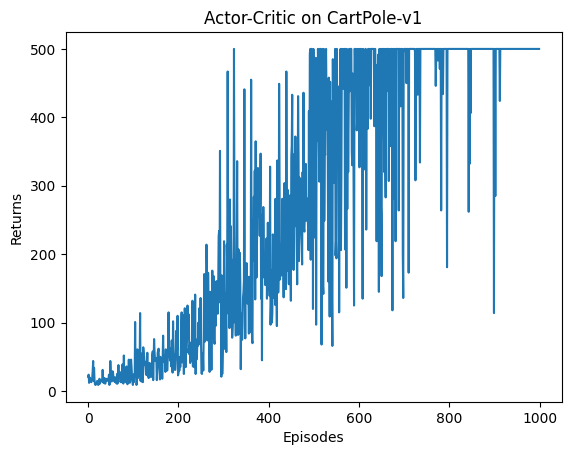

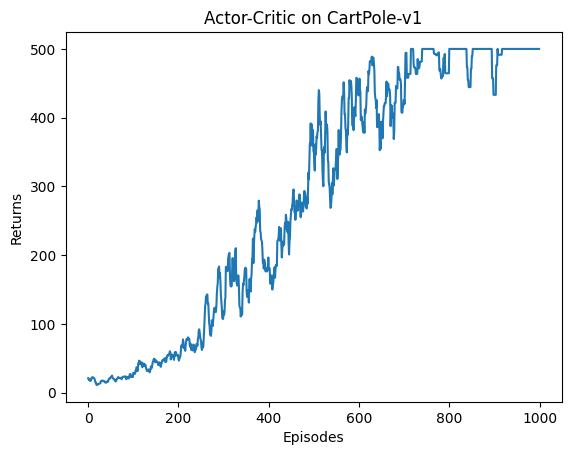

In [71]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

### 11. TRPO算法